In [1]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'speech-emotion-recognition-en:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1118008%2F1877714%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240612%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240612T045105Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D49d5ed1e65db61ed92920a15b697de8438f549b7aeeb02a9a294d5d7e8940bf994e75ca1b7752845089b25b1f7b8ab29925e31df60bcd4136e5929e41a76119572fdbf19cc74f8a824cd29bd9a501b62039aedb010c1ad48f3e1486eb9264cd94356c60e90807172d108b533b2c5196fb93732e09df25357acb81349c7f655a21ebec038b33b16811350216145b3c99d785fd3a7138893898f4a7e803280502c152f95a837fe4187461f86dcc0240c993d87a50aab481e1b6f8d09ddb5c4a8fdbaf4729cf81f15fd74ad585ff8ea71c93250ff299b77c28928a72b964420718f0deacda785599df12001e2abfe3250f2d509acafcc7750d0d1aaf7850313d408'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1035070855 bytes downloaded
Downloaded and uncompressed: speech-emotion-recognition-en
Data source import complete.


<a id="2"></a>
# <p style="padding:10px;background-color:#0C4C79 ;margin:0;color:#ffffff;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Import Libraries </p>

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display

# to play the audio files
from IPython.display import Audio


from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from collections.abc import Iterable

from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, BatchNormalization
from keras import layers, callbacks

<a id="3"></a>
# <p style="padding:10px;background-color:#0C4C79 ;margin:0;color:#ffffff;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Import Dataset </p>

In [4]:
Root_dir = '/kaggle/input/speech-emotion-recognition-en'

In [5]:
Crema_path = Root_dir + "/Crema/"
Ravdess_path = Root_dir + "/Ravdess/audio_speech_actors_01-24/"
Savee_path = Root_dir + "/Savee/"
Tess_path = Root_dir + "/Tess/"

In [6]:
Crema_dir_list = os.listdir(Crema_path)
Ravdess_dir_list = os.listdir(Ravdess_path)
Savee_dir_list = os.listdir(Savee_path)
Tess_dir_list = os.listdir(Tess_path)

* **[Table of Content](#0)**

<a id="4"></a>
# <p style="padding:10px;background-color:#0C4C79 ;margin:0;color:#ffffff;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Data PreProcessing </p>

# Crema

In [7]:
Ex_Crema_dir_list = Crema_dir_list[:15]
Ex_Crema_dir_list

['1015_TSI_NEU_XX.wav',
 '1017_TIE_DIS_XX.wav',
 '1012_TAI_ANG_XX.wav',
 '1081_TIE_ANG_XX.wav',
 '1048_MTI_SAD_XX.wav',
 '1004_ITH_DIS_XX.wav',
 '1051_TIE_SAD_XX.wav',
 '1088_TIE_HAP_XX.wav',
 '1046_TIE_DIS_XX.wav',
 '1084_TAI_SAD_XX.wav',
 '1005_IOM_FEA_XX.wav',
 '1017_ITS_ANG_XX.wav',
 '1066_MTI_SAD_XX.wav',
 '1029_IWW_ANG_XX.wav',
 '1036_WSI_ANG_XX.wav']

In [8]:
emotions_crema = []
paths_crema = []

for it in Crema_dir_list:
    # storing file paths
    paths_crema.append(Crema_path + it)
    # storing file emotions
    part = it.split('_')
    if part[2] == 'SAD':
        emotions_crema.append('sad')
    elif part[2] == 'ANG':
        emotions_crema.append('angry')
    elif part[2] == 'DIS':
        emotions_crema.append('disgust')
    elif part[2] == 'FEA':
        emotions_crema.append('fear')
    elif part[2] == 'HAP':
        emotions_crema.append('happy')
    elif part[2] == 'NEU':
        emotions_crema.append('neutral')
    else:
        emotions_crema.append('Unknown')

# dataframe for emotion of files
emotions_crema_df = pd.DataFrame(emotions_crema, columns=['Emotions'])

# dataframe for path of files.
path_crema_df = pd.DataFrame(paths_crema, columns=['Path'])
Crema_df = pd.concat([emotions_crema_df, path_crema_df], axis=1)
print(Crema_df.shape)
Crema_df.head().style.set_properties(**{'background-color': '#9490ff',
                           'color': 'black',
                           'border-color': 'black'})


(7442, 2)


In [9]:
[Crema_df["Emotions"].unique().tolist() for i in Crema_df.columns]

[['neutral', 'disgust', 'angry', 'sad', 'happy', 'fear'],
 ['neutral', 'disgust', 'angry', 'sad', 'happy', 'fear']]

In [10]:
font1 = {'family':'Times New Roman','color':'blue','size':30}
font2 = {'family':'Times New Roman','color':'blue','size':20}
font3 = {'family':'Times New Roman','color':'blue','size':10}

<div style = 'border : 3px solid non; background-color:#f2f2f2 ; ;padding:10px'>


* **2- Plot the details of each dataset**

  - We can see the number of samples of each classes. Also we can consider the balance of the
    datasets.


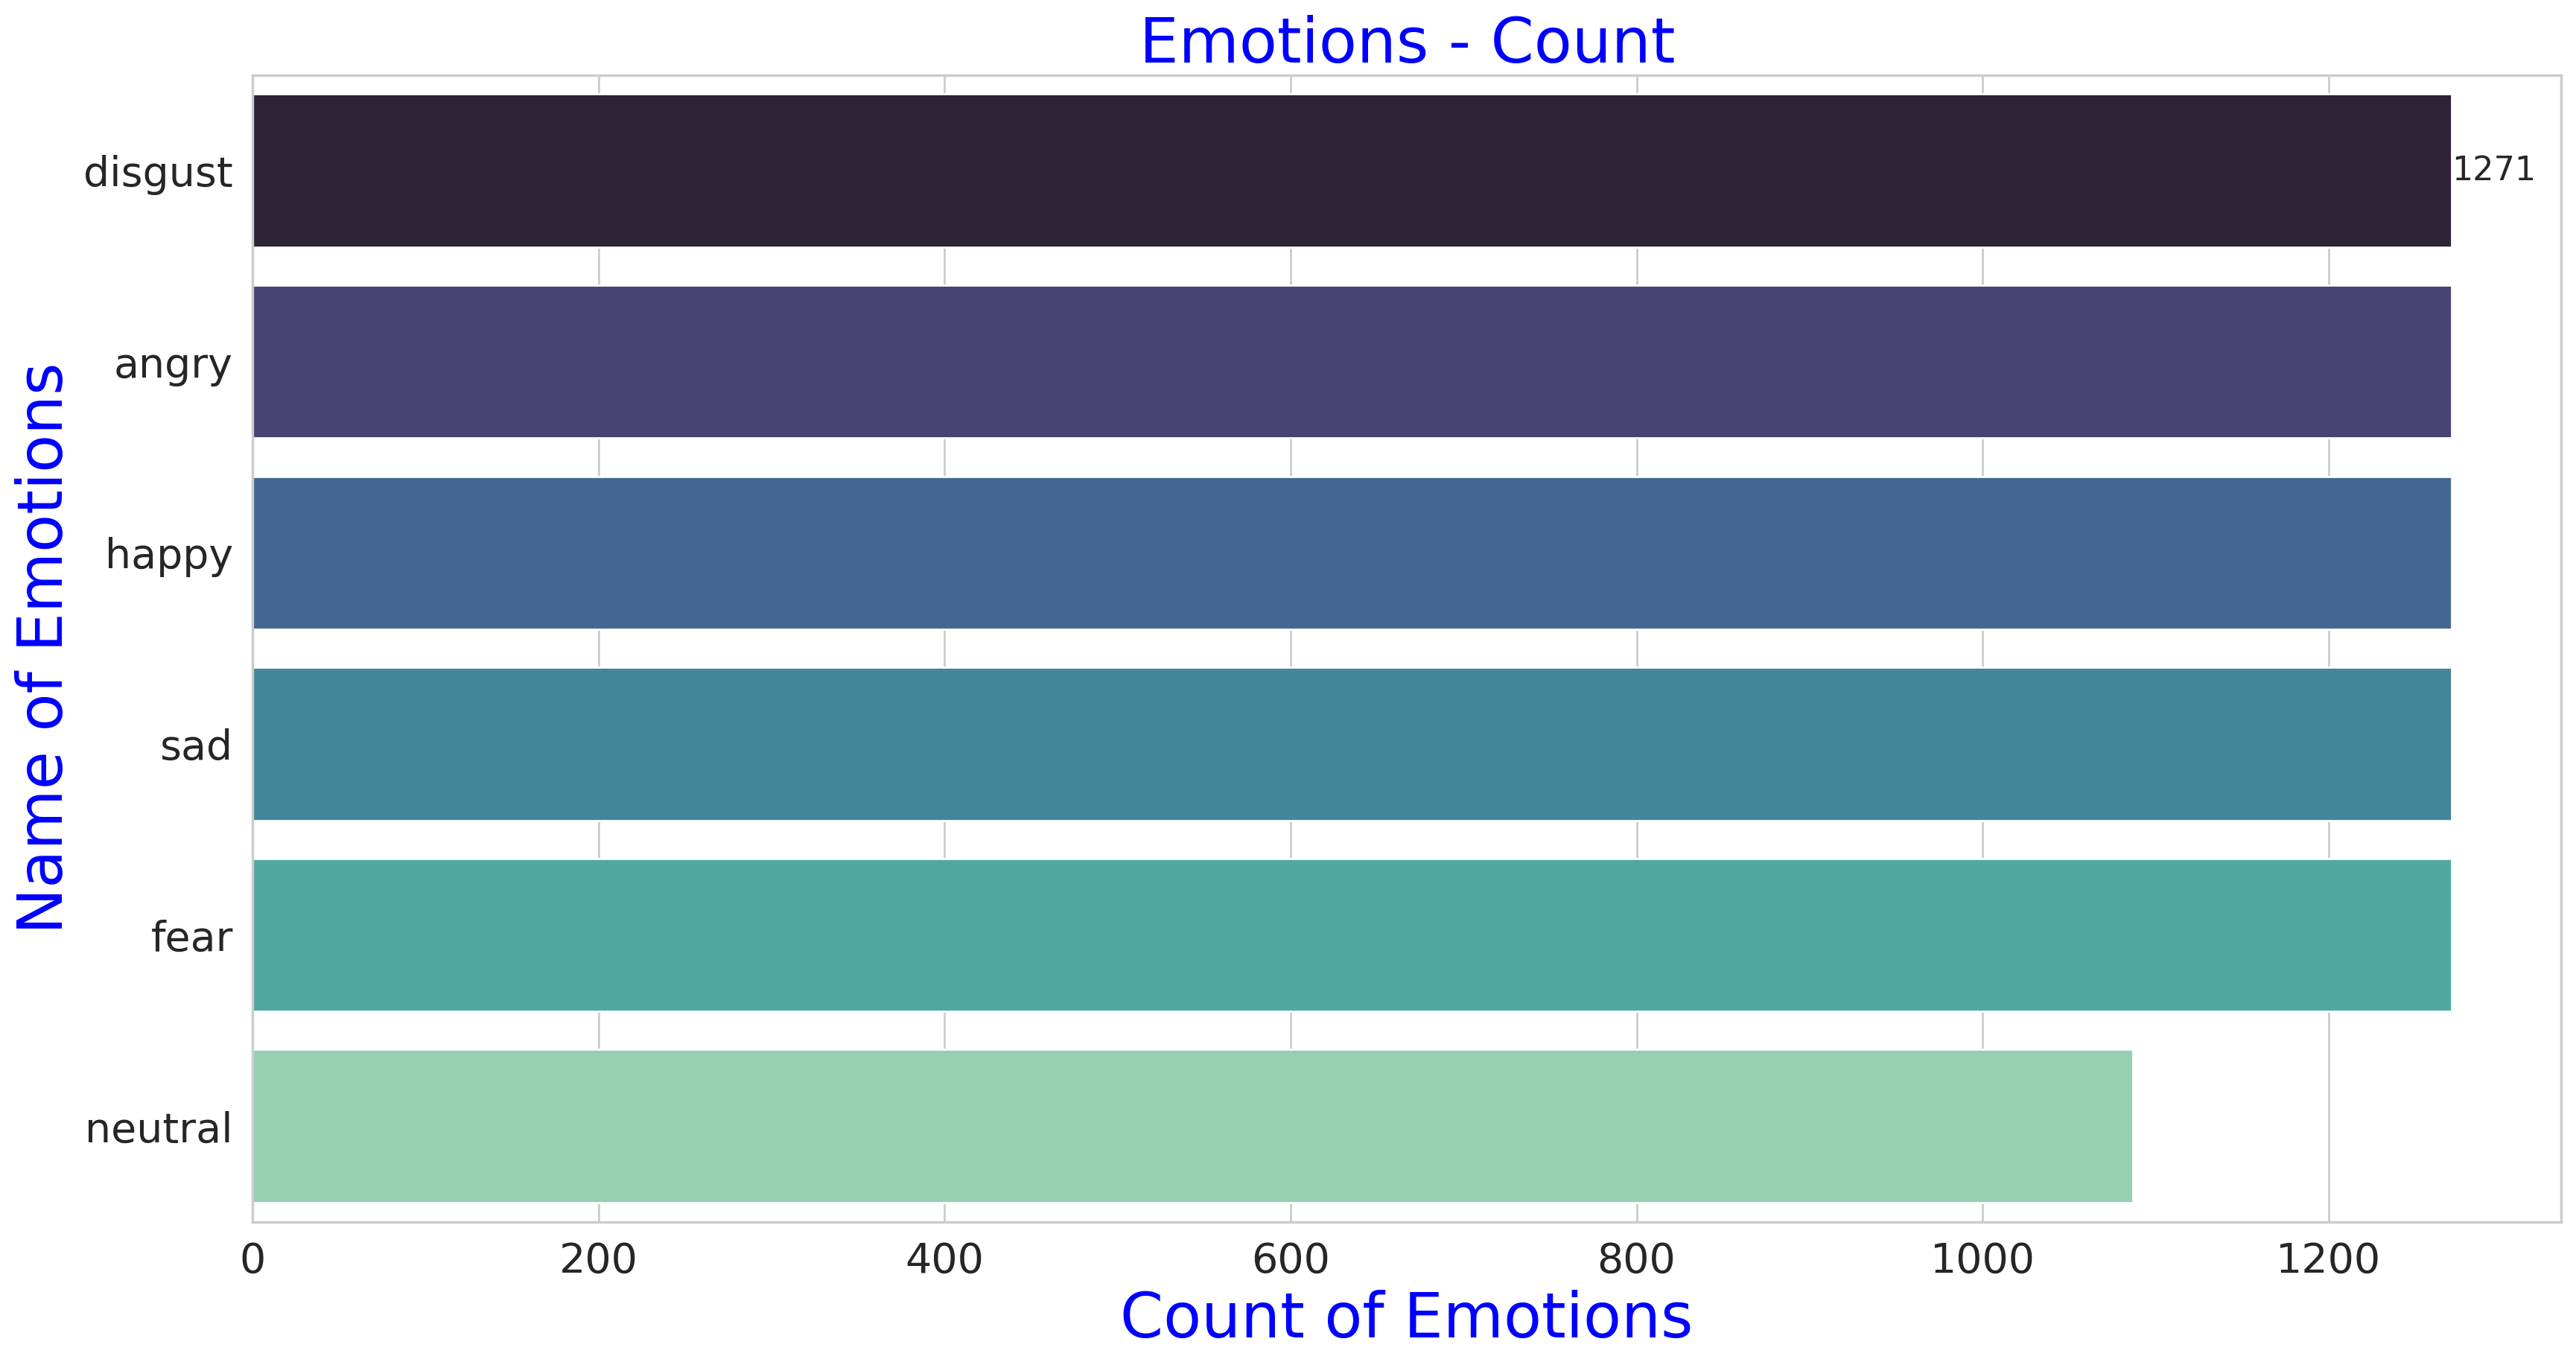

In [11]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Crema_df['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions", fontdict= font1)
plt.xlabel("Count of Emotions", fontdict= font1)
plt.title("Emotions - Count", fontdict= font1)
plt.show()

# Ravdess

In [12]:
Ex_Ravdess_dir_list = Ravdess_dir_list[:15]
Ex_Ravdess_dir_list

['Actor_15',
 'Actor_04',
 'Actor_10',
 'Actor_03',
 'Actor_08',
 'Actor_13',
 'Actor_01',
 'Actor_23',
 'Actor_17',
 'Actor_21',
 'Actor_18',
 'Actor_09',
 'Actor_11',
 'Actor_12',
 'Actor_14']

That's not enough


In [13]:
emotions_ravdess = []
path_ravdess = []

for it in Ravdess_dir_list:
    # There are 20 actors
    actor = os.listdir(Ravdess_path + it)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        emotions_ravdess.append(int(part[2]))
        path_ravdess.append(Ravdess_path + it + '/' + file)


emotion_ravdess_df = pd.DataFrame(emotions_ravdess, columns=['Emotions'])

path_ravdess_df = pd.DataFrame(path_ravdess, columns=['Path'])
Ravdess_df = pd.concat([emotion_ravdess_df, path_ravdess_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm',
                             3:'happy', 4:'sad', 5:'angry',
                             6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head().style.set_properties(**{'background-color': '#9490ff',
                           'color': 'black',
                           'border-color': 'black'})

In [14]:
[Ravdess_df["Emotions"].unique().tolist() for i in Ravdess_df.columns]

[['surprise', 'fear', 'angry', 'disgust', 'calm', 'sad', 'neutral', 'happy'],
 ['surprise', 'fear', 'angry', 'disgust', 'calm', 'sad', 'neutral', 'happy']]

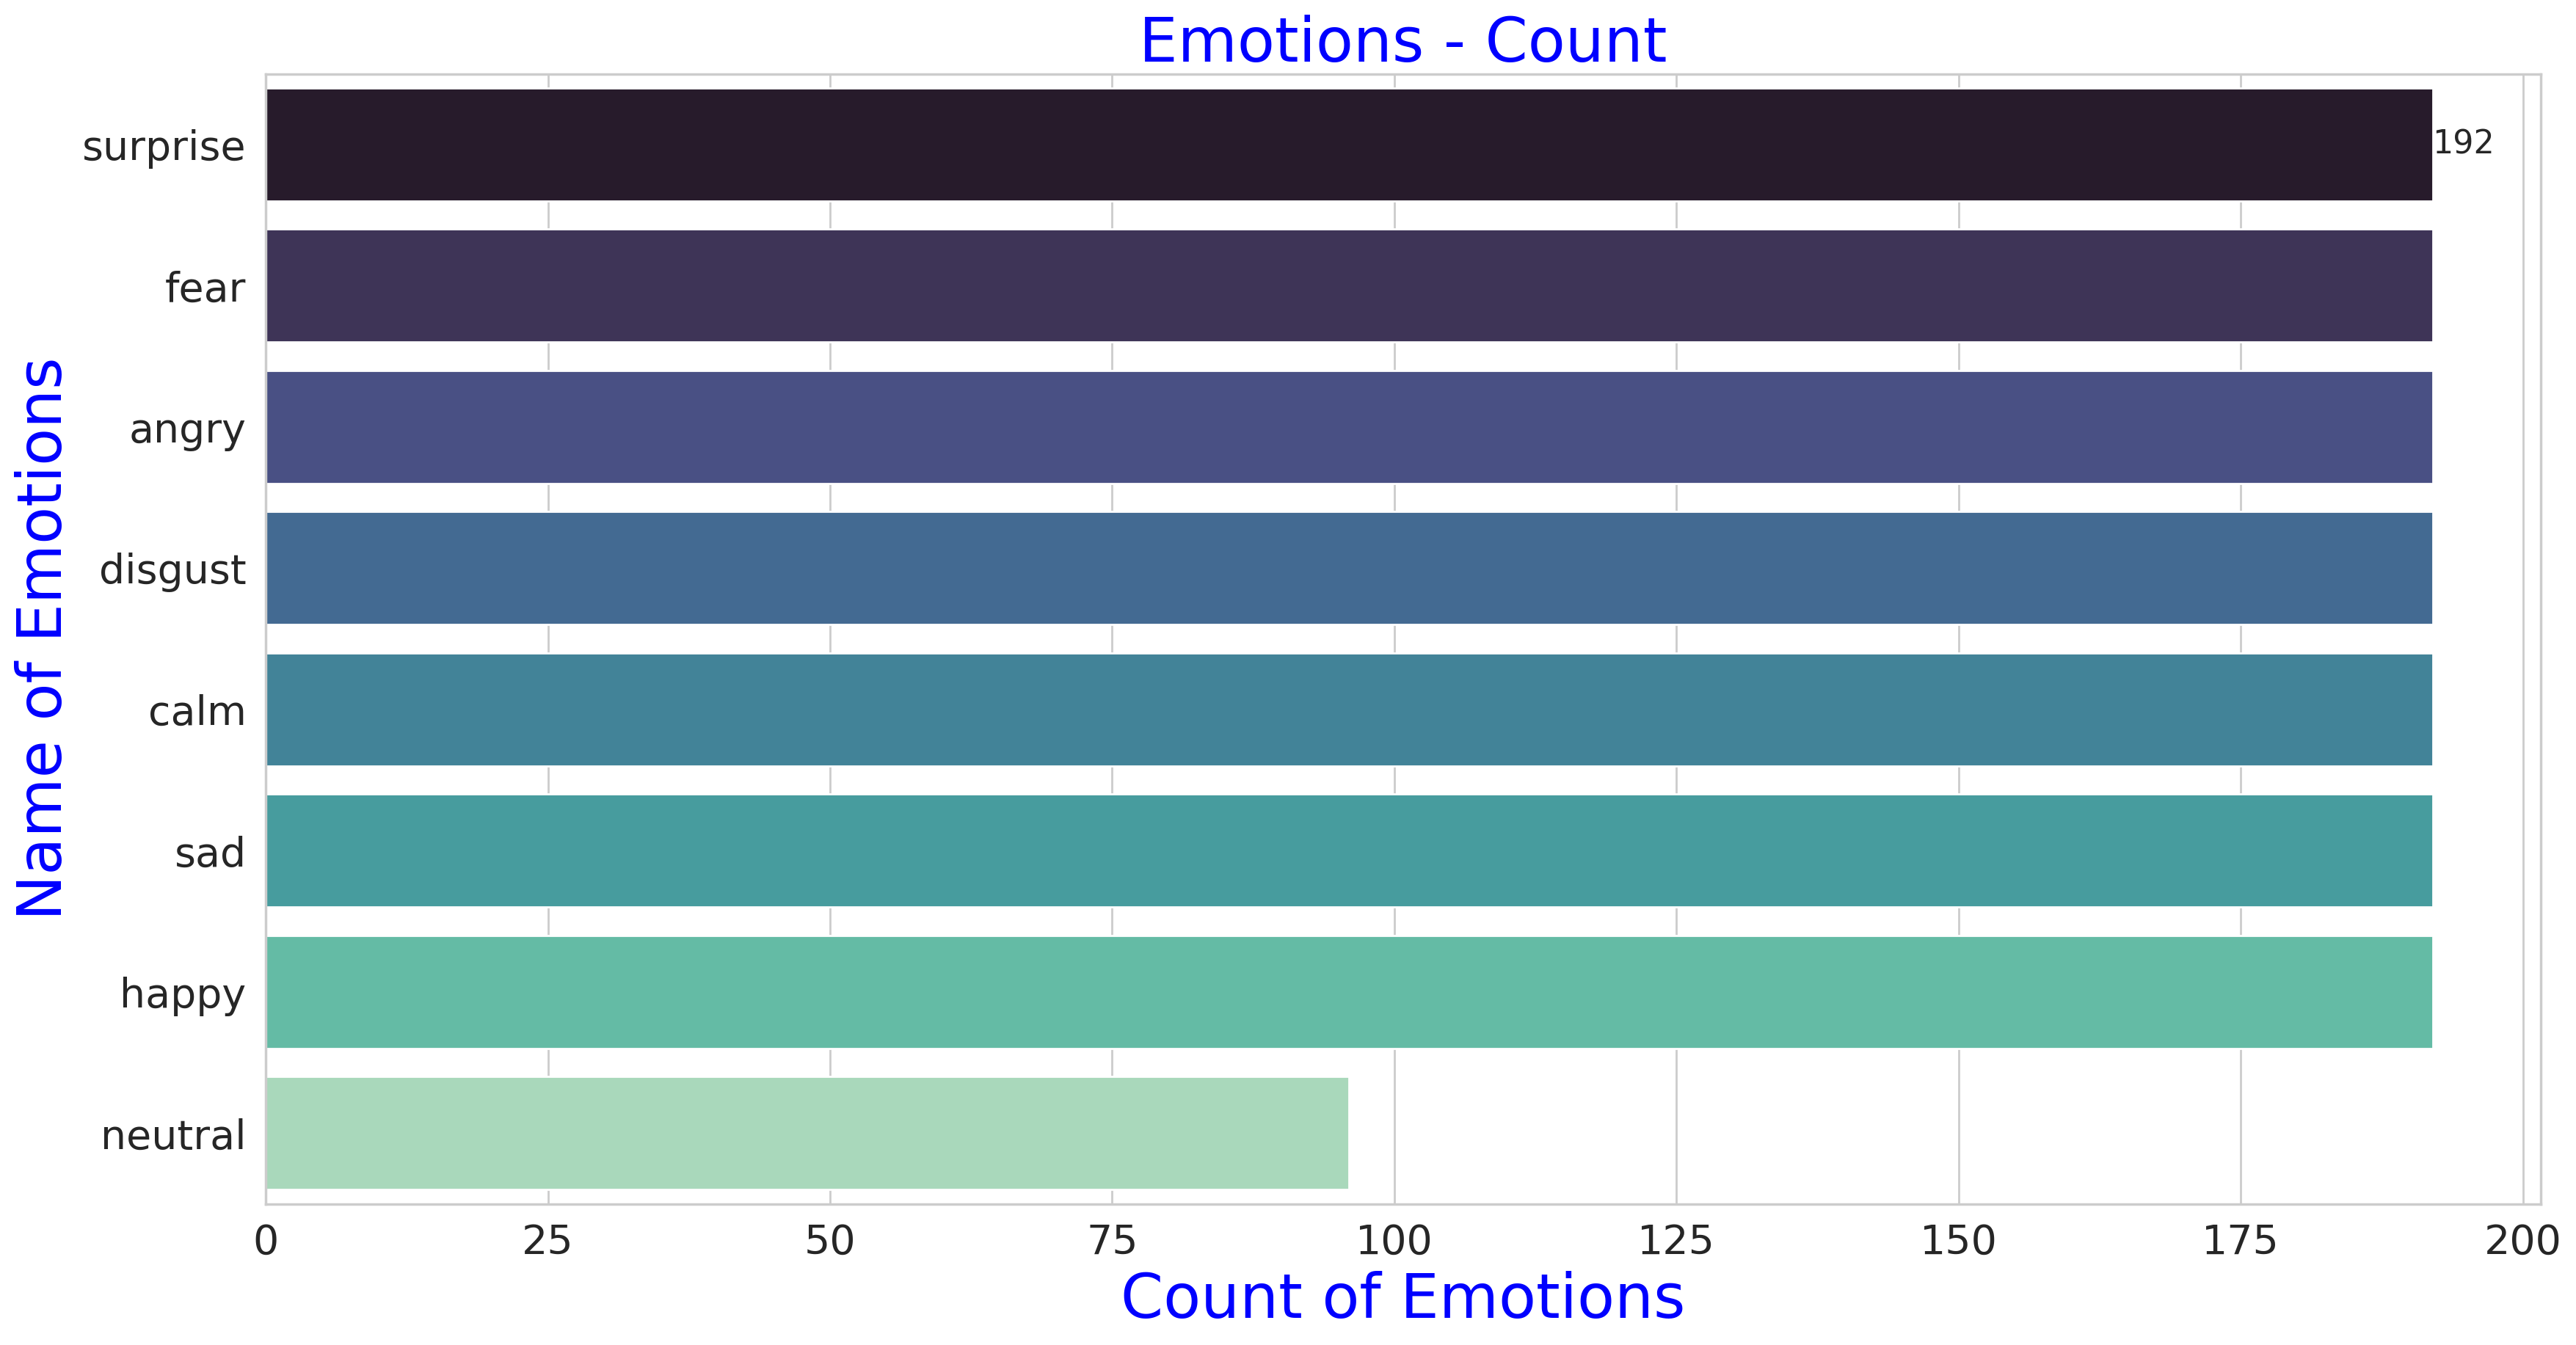

In [15]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Ravdess_df['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions", fontdict= font1)
plt.xlabel("Count of Emotions", fontdict= font1)
plt.title("Emotions - Count", fontdict= font1)
plt.show()

# Savee

In [16]:
Ex_Savee_dir_list = Savee_dir_list[:15]
Ex_Savee_dir_list

['JK_a14.wav',
 'JE_su06.wav',
 'DC_n21.wav',
 'DC_f10.wav',
 'KL_h01.wav',
 'JE_n12.wav',
 'KL_n13.wav',
 'DC_n12.wav',
 'KL_su07.wav',
 'JE_n30.wav',
 'DC_d13.wav',
 'JE_d07.wav',
 'JE_h01.wav',
 'JE_n23.wav',
 'DC_n07.wav']

In [17]:
emotions_savee = []
path_savee = []

for it in Savee_dir_list:
    path_savee.append(Savee_path + it)
    part = it.split('_')[1]
    part = part[:-6]
    if part == 'a':
        emotions_savee.append('angry')
    elif part == 'd':
        emotions_savee.append('disgust')
    elif part == 'f':
        emotions_savee.append('fear')
    elif part == 'h':
        emotions_savee.append('happiness')
    elif part == 'n':
        emotions_savee.append('neutral')
    elif part == 'sa':
        emotions_savee.append('sadness')
    elif part == 'su':
        emotions_savee.append('surprise')

    else:
        emotions_savee.append('Unknown')

# dataframe for emotion of files
emotion_savee_df = pd.DataFrame(emotions_savee, columns=['Emotions'])

# dataframe for path of files.
path_savee_df = pd.DataFrame(path_savee, columns=['Path'])
Savee_df = pd.concat([emotion_savee_df, path_savee_df], axis=1)
Savee_df.head().style.set_properties(**{'background-color': '#9490ff',
                           'color': 'black',
                           'border-color': 'black'})

In [18]:
[Savee_df["Emotions"].unique().tolist() for i in Savee_df.columns]

[['angry', 'surprise', 'neutral', 'fear', 'happiness', 'disgust', 'sadness'],
 ['angry', 'surprise', 'neutral', 'fear', 'happiness', 'disgust', 'sadness']]

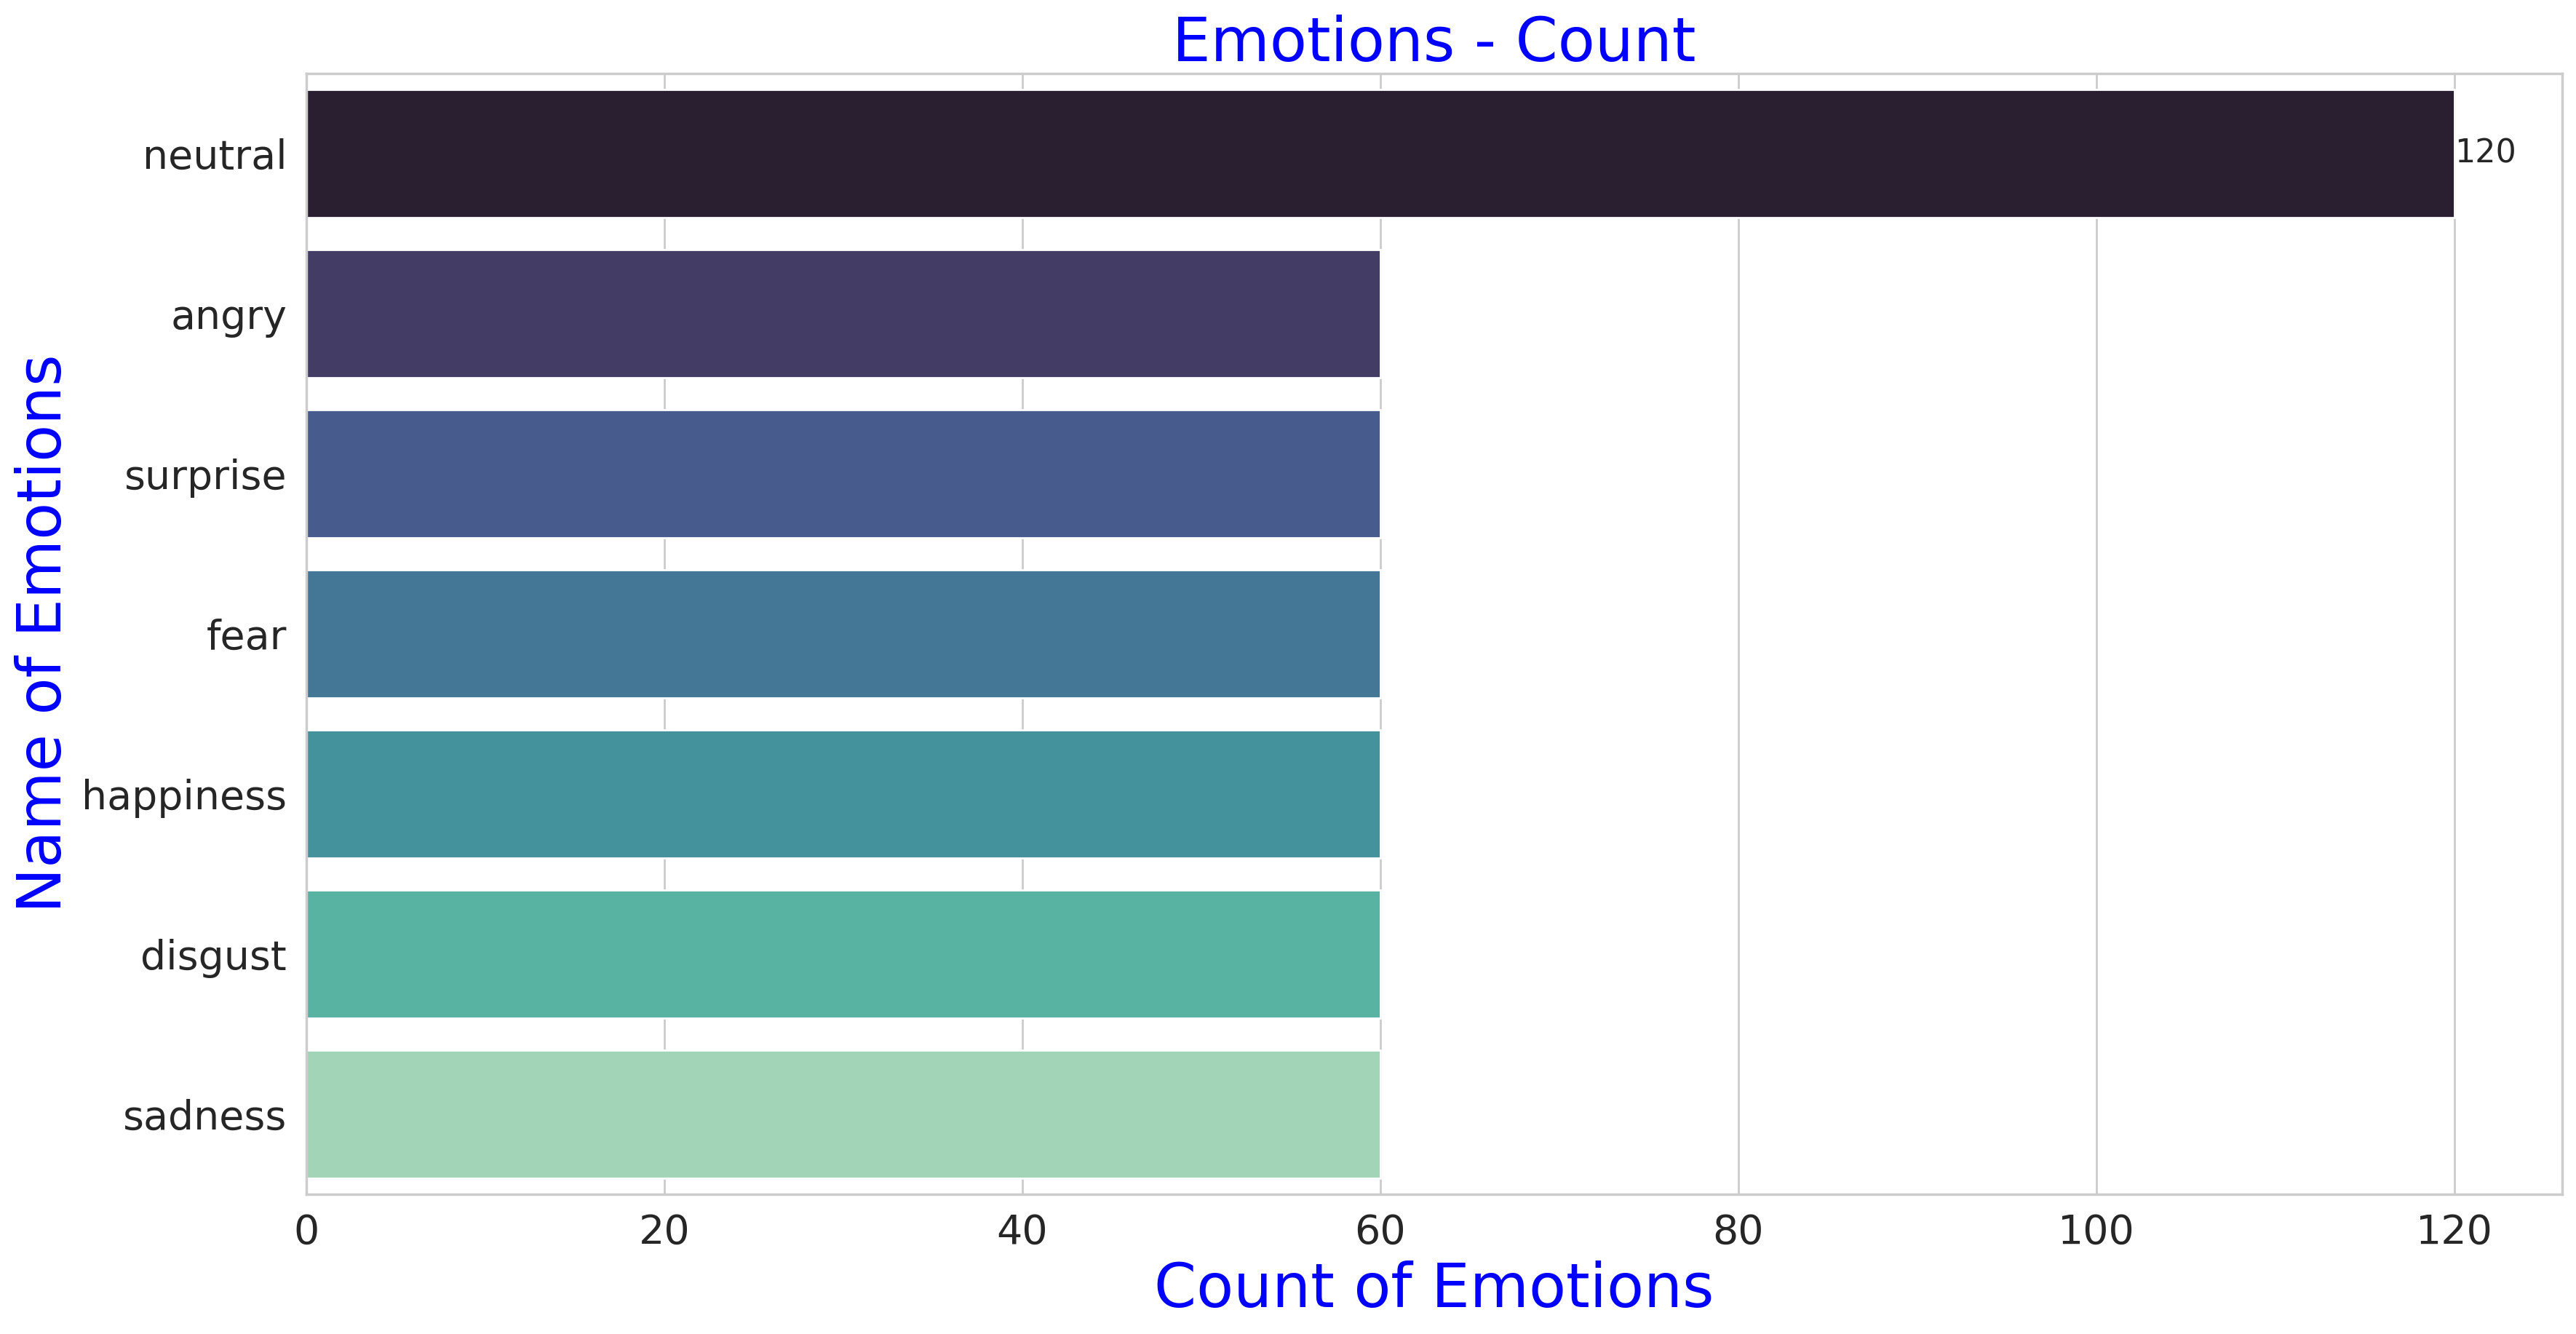

In [19]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Savee_df['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions", fontdict= font1)
plt.xlabel("Count of Emotions", fontdict= font1)
plt.title("Emotions - Count", fontdict= font1)
plt.show()

In [20]:
Ex_Tess_dir_list = Tess_dir_list[:15]
Ex_Tess_dir_list

['OAF_angry',
 'OAF_happy',
 'OAF_Sad',
 'OAF_neutral',
 'YAF_sad',
 'YAF_disgust',
 'OAF_disgust',
 'OAF_Fear',
 'YAF_angry',
 'YAF_neutral',
 'YAF_fear',
 'OAF_Pleasant_surprise',
 'YAF_pleasant_surprised',
 'YAF_happy']

# Tess

In [21]:
emotions_tess = []
path_tess = []

for it in Tess_dir_list:
    directories = os.listdir(Tess_path + '/' + it)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            emotions_tess.append('surprise')
        else:
            emotions_tess.append(part)
        path_tess.append(Tess_path + it + '/' + file)



# dataframe for emotion of files
emotion_tess_df = pd.DataFrame(emotions_tess, columns=['Emotions'])

# dataframe for path of files.
path_tess_df = pd.DataFrame(path_tess, columns=['Path'])
Tess_df = pd.concat([emotion_tess_df, path_tess_df], axis=1)
Tess_df.head().style.set_properties(**{'background-color': '#9490ff',
                           'color': 'black',
                           'border-color': 'black'})

In [22]:
[Tess_df["Emotions"].unique().tolist() for i in Tess_df.columns]

[['angry', 'happy', 'sad', 'neutral', 'disgust', 'fear', 'surprise'],
 ['angry', 'happy', 'sad', 'neutral', 'disgust', 'fear', 'surprise']]

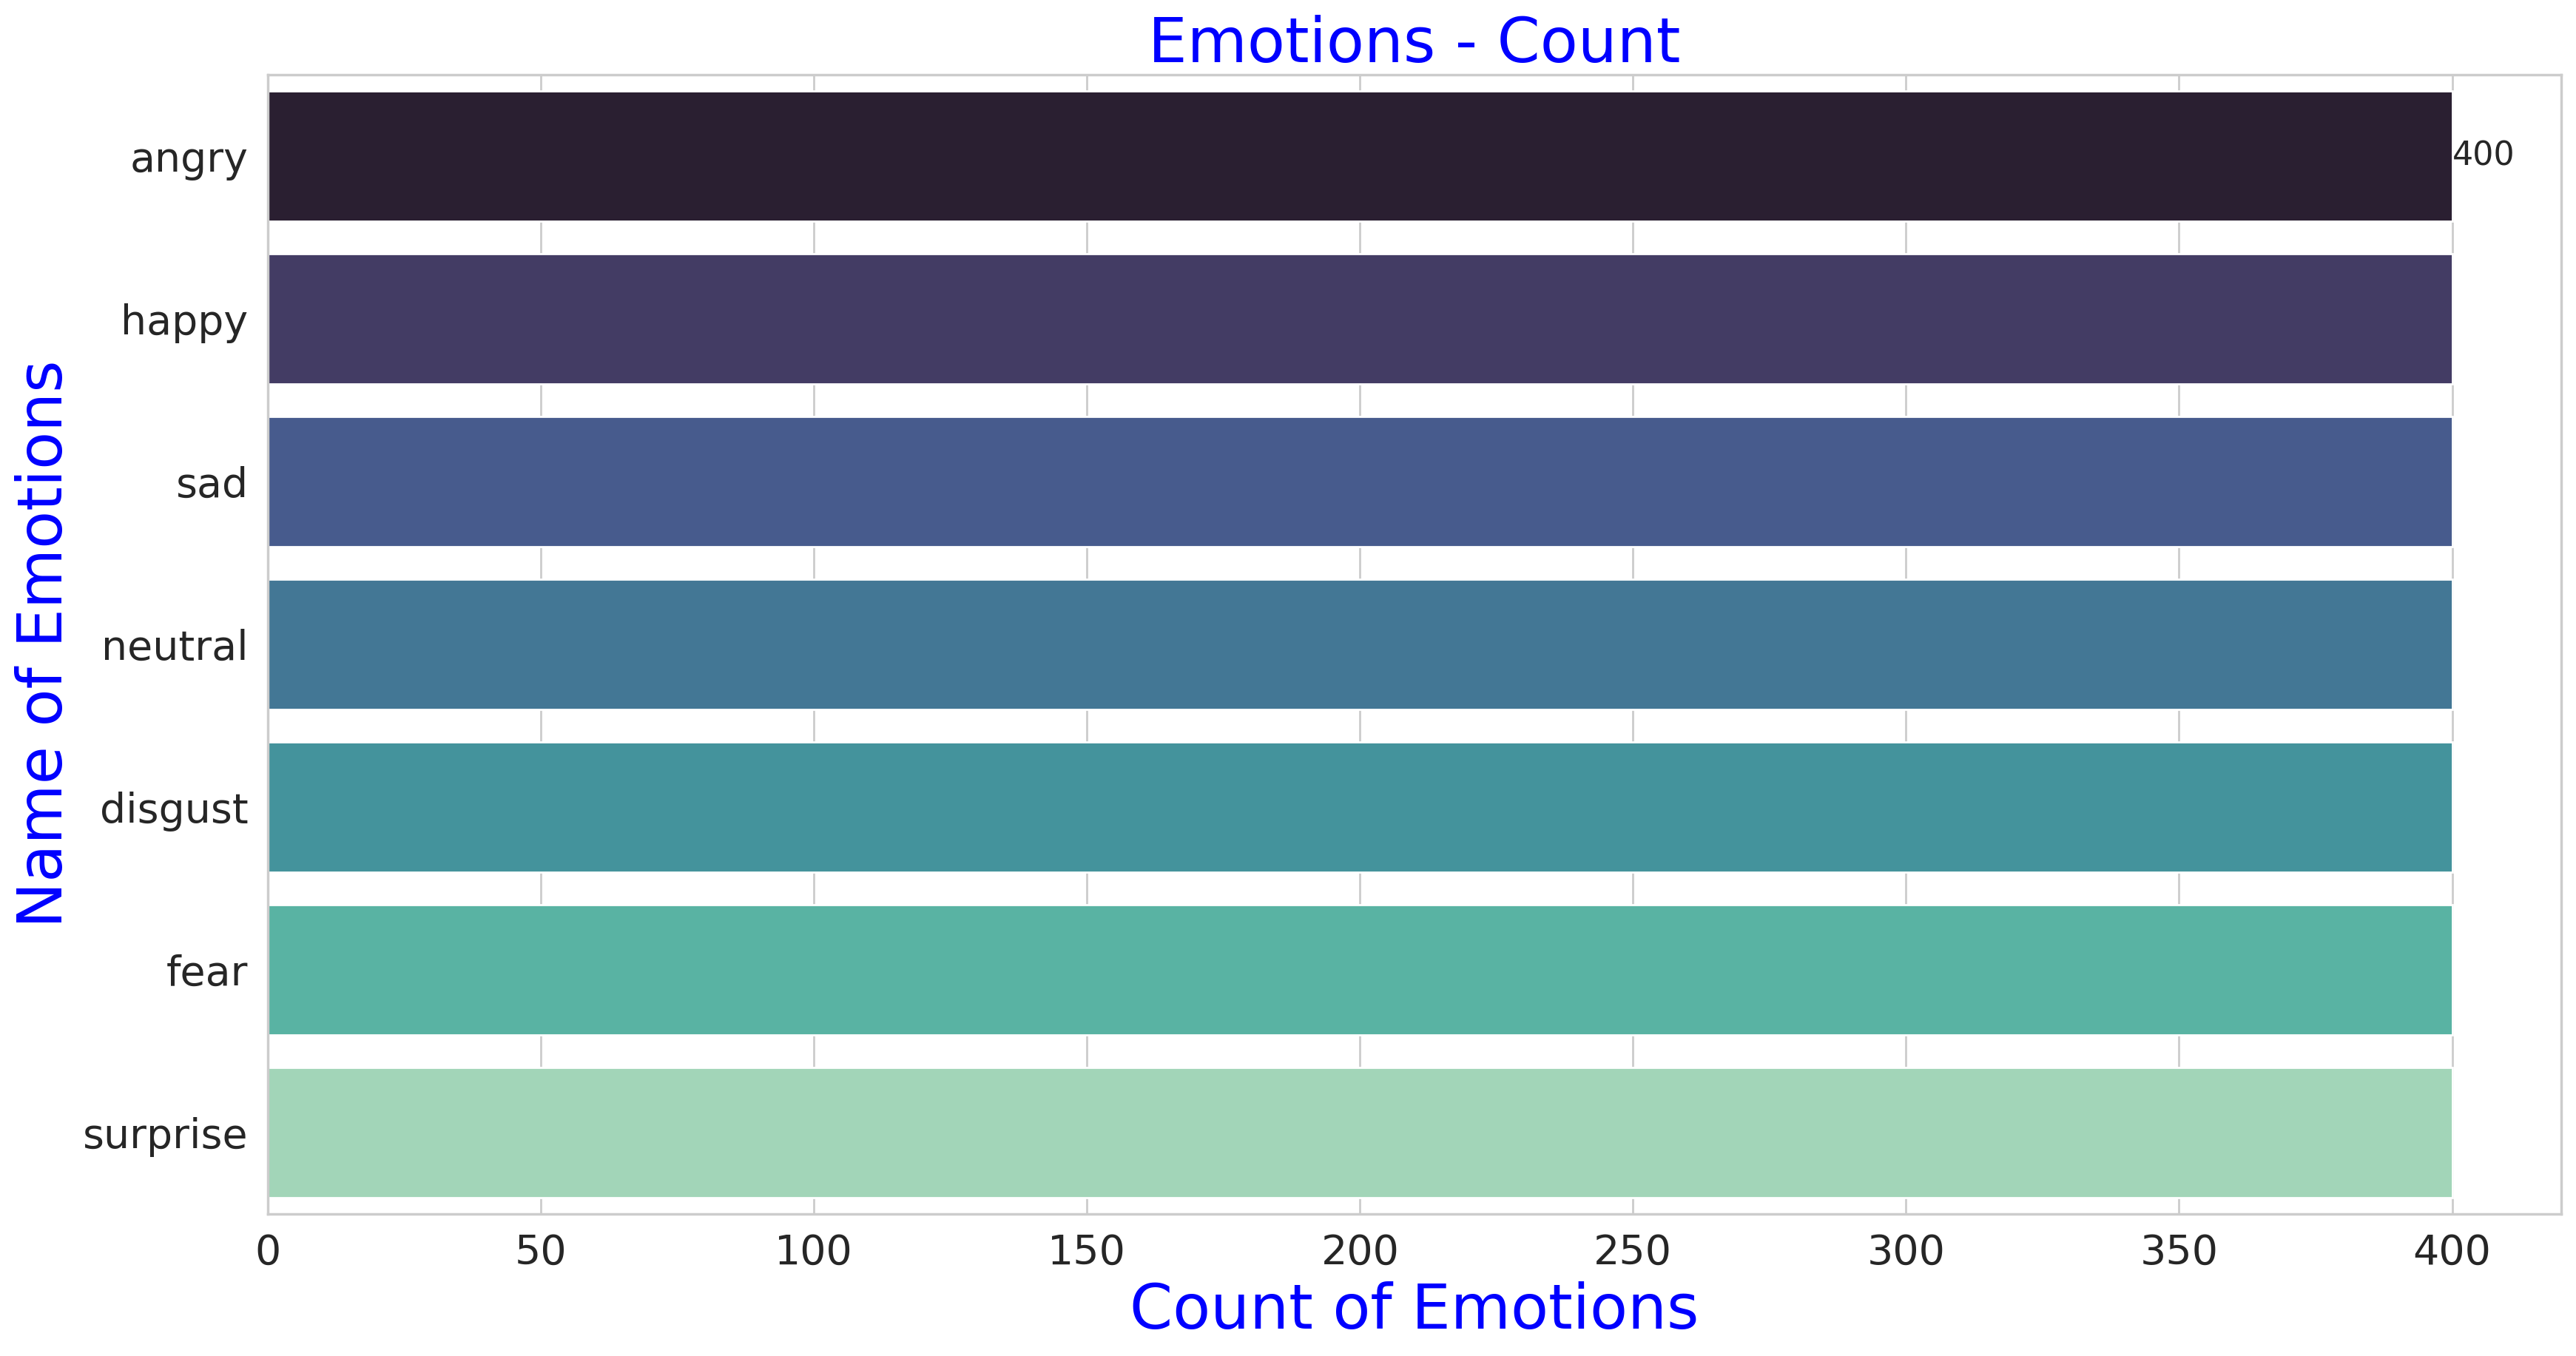

In [23]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Tess_df['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions", fontdict= font1)
plt.xlabel("Count of Emotions", fontdict= font1)
plt.title("Emotions - Count", fontdict= font1)
plt.show()

In [24]:
Sum_df = pd.concat([Crema_df, Ravdess_df, Savee_df, Tess_df], axis = 0)
Sum_df.to_csv("Sum_df.csv",index=False)
Sum_df.head().style.set_properties(**{'background-color': '#9490ff',
                           'color': 'black',
                           'border-color': 'black'})

In [25]:
[Sum_df["Emotions"].unique().tolist() for i in Sum_df.columns]

[['neutral',
  'disgust',
  'angry',
  'sad',
  'happy',
  'fear',
  'surprise',
  'calm',
  'happiness',
  'sadness'],
 ['neutral',
  'disgust',
  'angry',
  'sad',
  'happy',
  'fear',
  'surprise',
  'calm',
  'happiness',
  'sadness']]

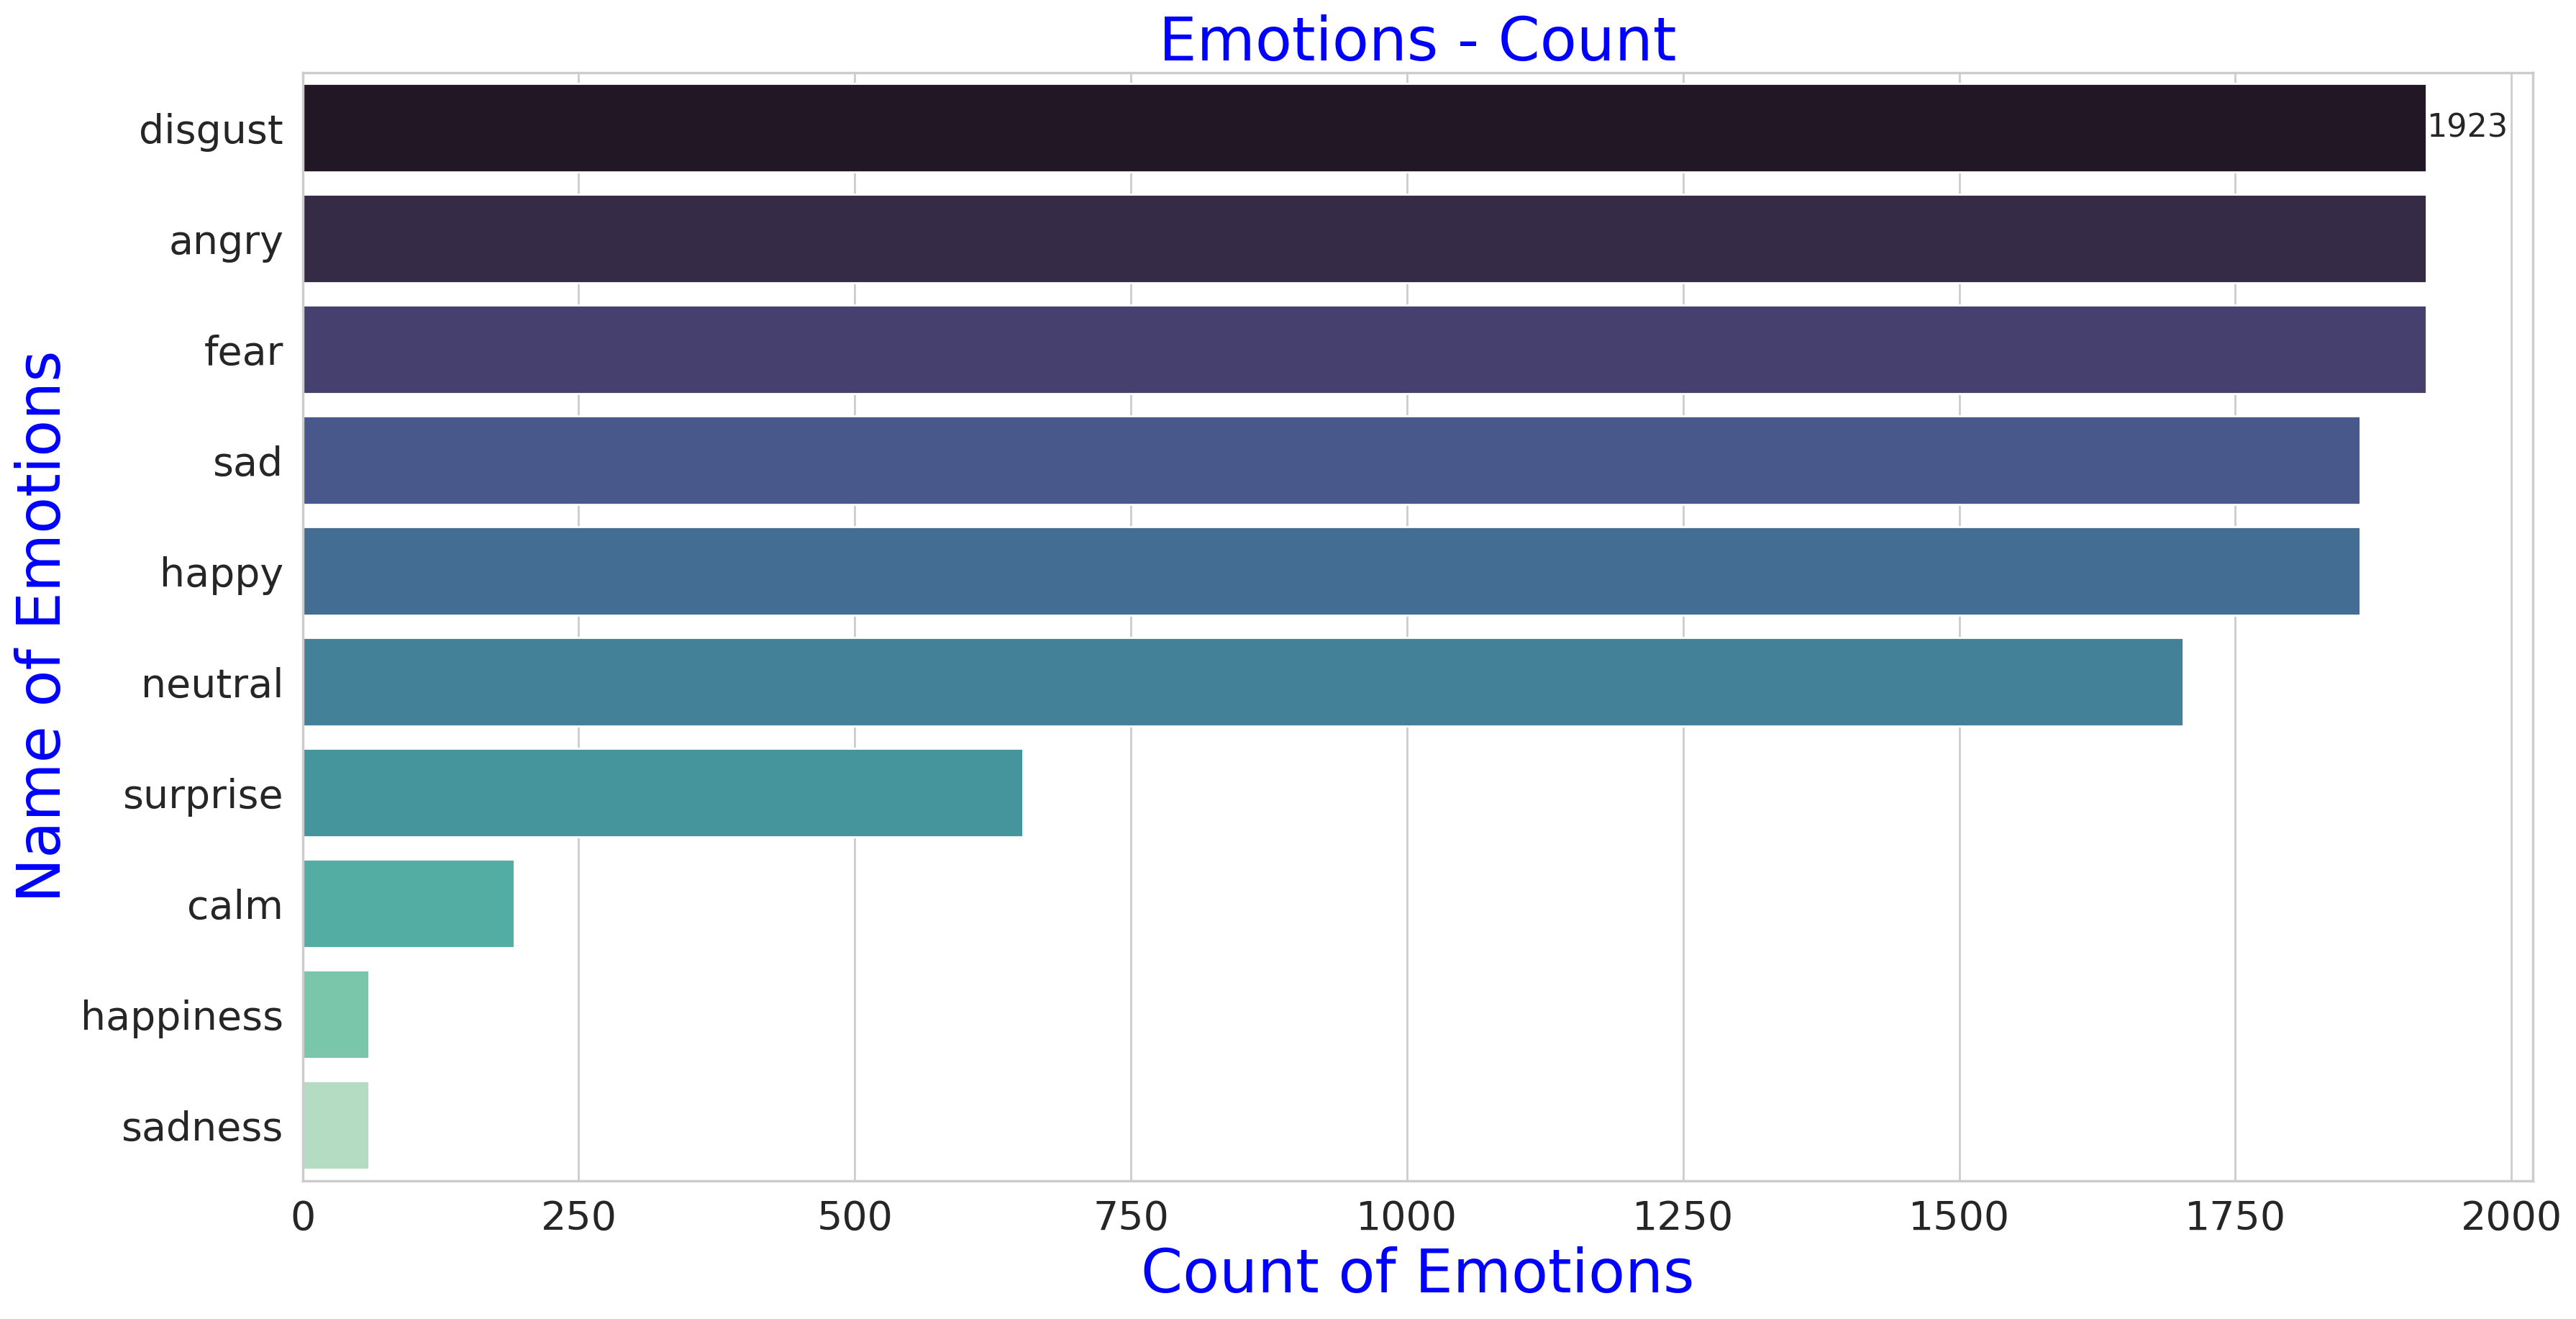

In [26]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Sum_df['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions", fontdict= font1)
plt.xlabel("Count of Emotions", fontdict= font1)
plt.title("Emotions - Count", fontdict= font1)
plt.show()

<div style = 'border : 3px solid non; background-color:#f2f2f2 ; ;padding:10px'>


What if we replace "Happines" to "Happy" and "Sadnees" to "Sad" and "calm" to "neutral".
I know that there are some differences between calm and neutal in meaning, but for avoiding unbalance samples, we can replace calm to neutral.

<div style = 'border : 3px solid non; background-color:#f2f2f2 ; ;padding:10px'>


As adjectives the difference between calm and neutralis that calm is peaceful, quiet, especially free from anger and anxiety while neutral is not taking sides in a conflict such as war; nonaligned.
As nouns the difference between calm and neutralis that calm is the state of being calm; peacefulness; absence of worry, anger, fear or other strong negative emotion while neutral is a nonaligned state, or a member of such a state.

In [27]:
Sum_df_rep = Sum_df
Sum_df_rep['Emotions'].replace('happiness', 'happy', inplace=True)
Sum_df_rep['Emotions'].replace('sadness', 'sad', inplace=True)
Sum_df_rep['Emotions'].replace('calm', 'neutral', inplace=True)

In [28]:
[Sum_df_rep["Emotions"].unique().tolist() for i in Sum_df_rep.columns]

[['neutral', 'disgust', 'angry', 'sad', 'happy', 'fear', 'surprise'],
 ['neutral', 'disgust', 'angry', 'sad', 'happy', 'fear', 'surprise']]

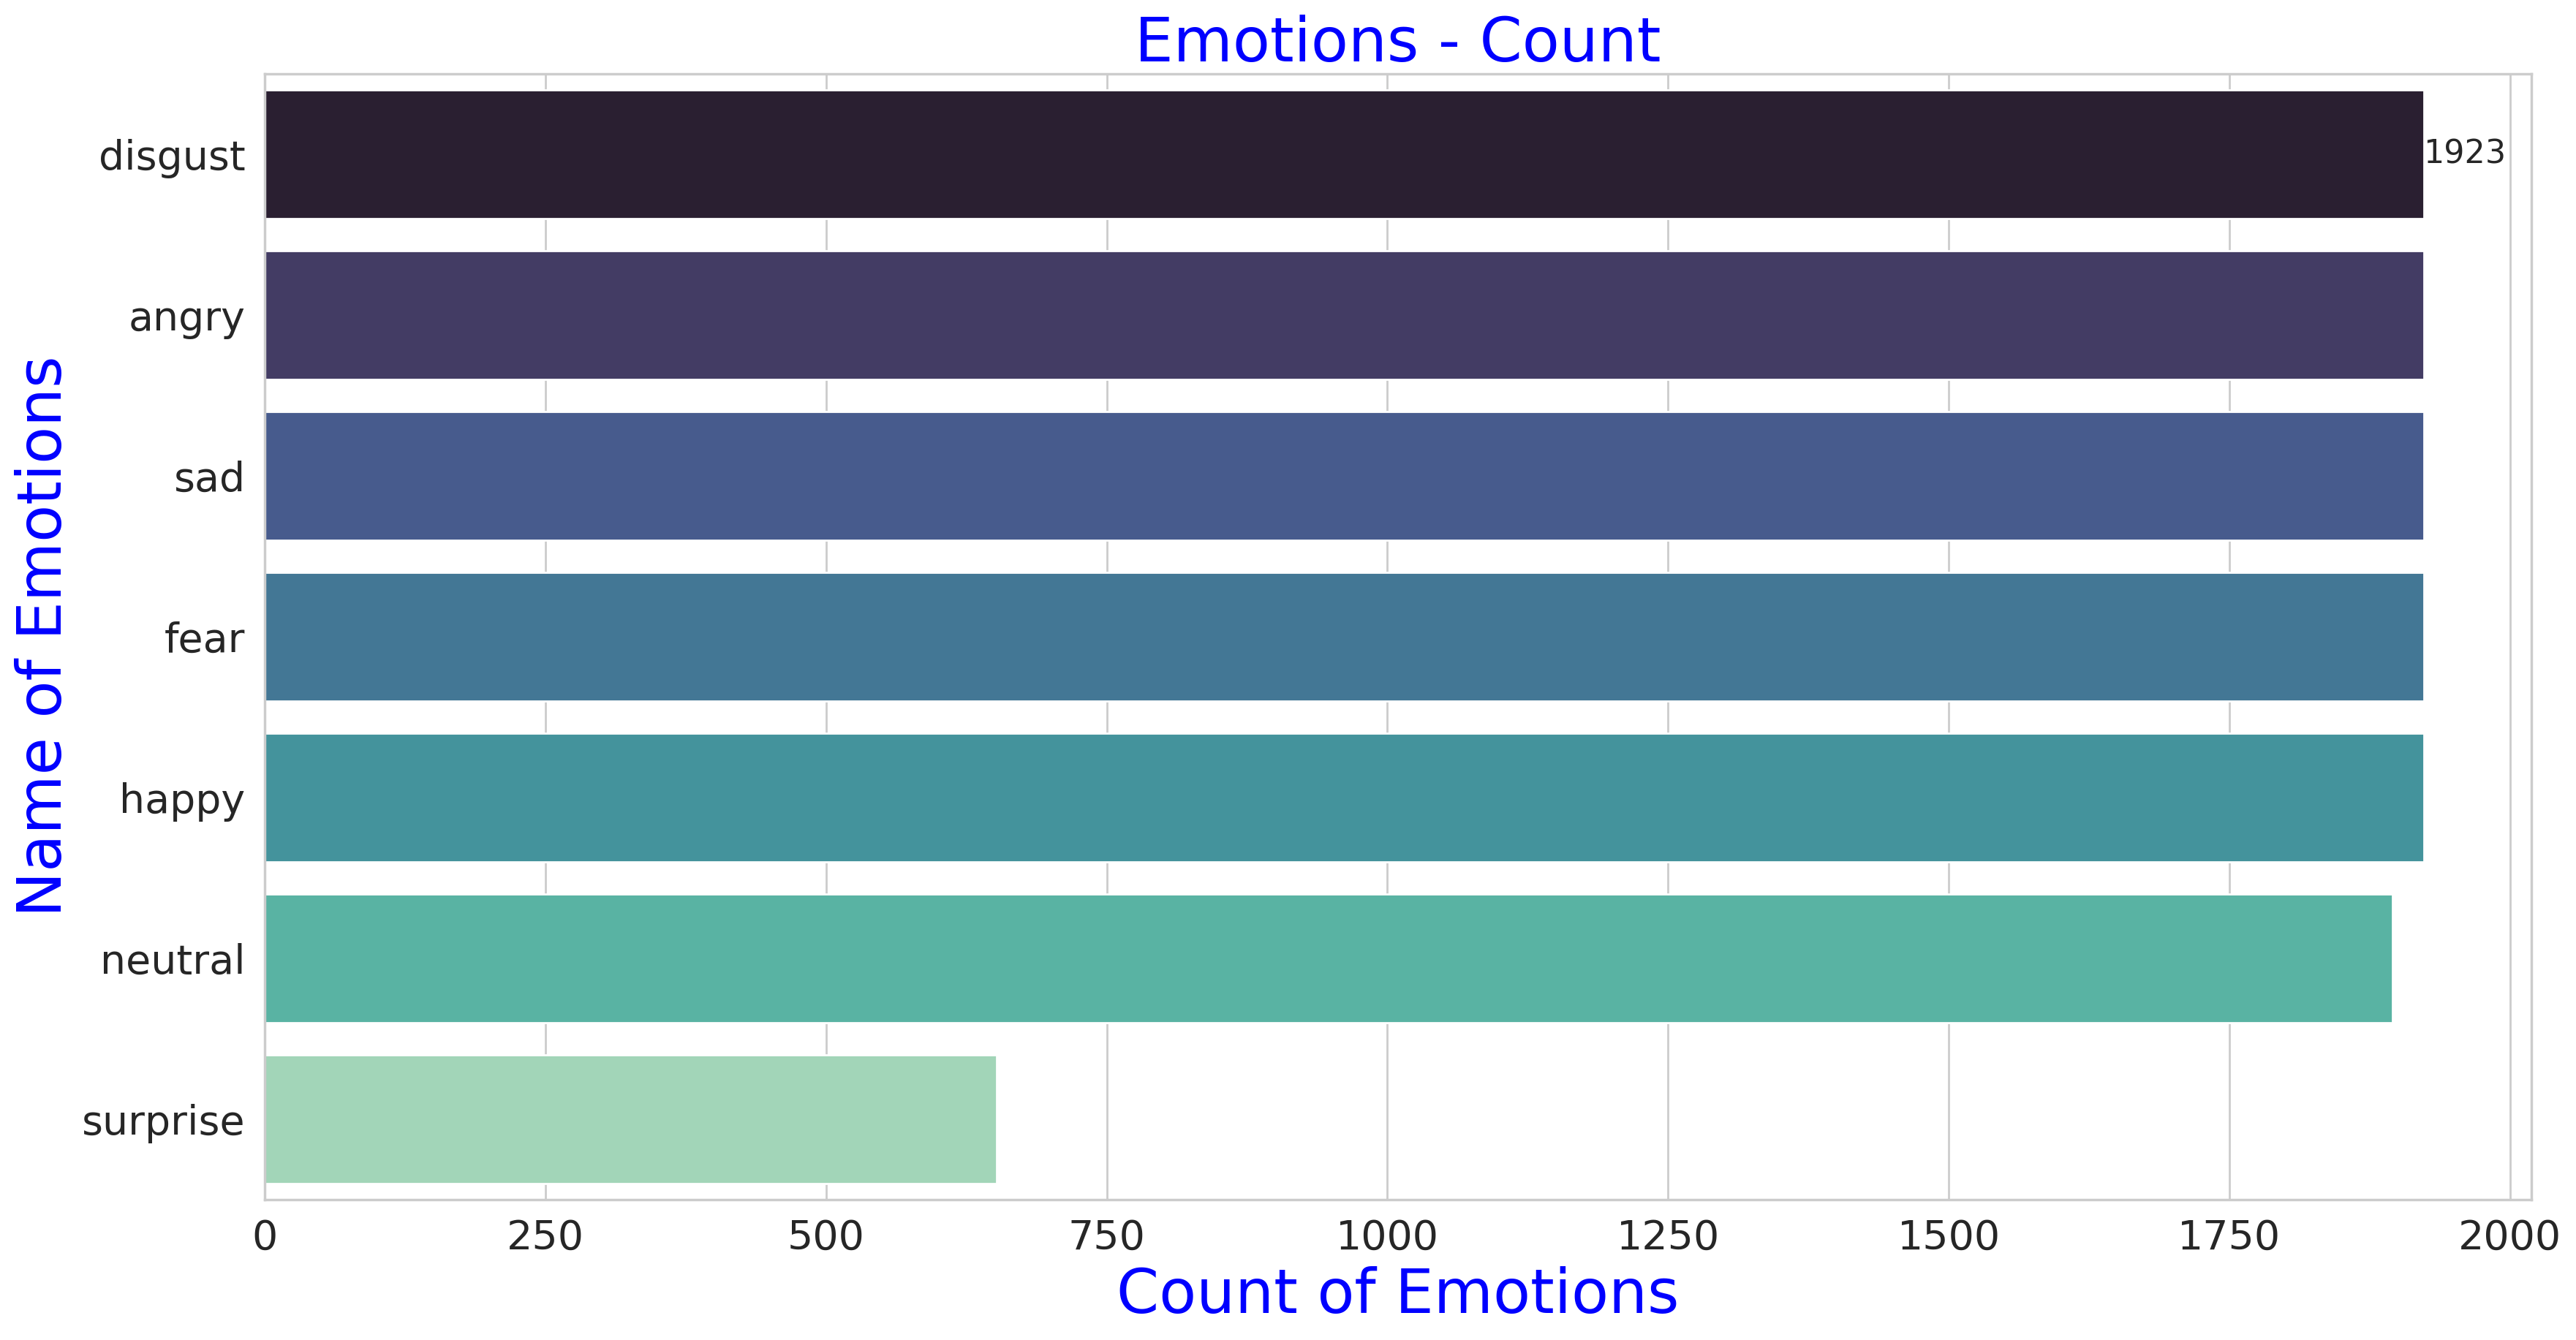

In [29]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Sum_df_rep['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions", fontdict= font1)
plt.xlabel("Count of Emotions", fontdict= font1)
plt.title("Emotions - Count", fontdict= font1)
plt.show()

<div style = 'border : 3px solid non; background-color:#f2f2f2 ; ;padding:10px'>



The analog-to-digital conversion process is called quantization and it's very similar to the way cameras capture video. A video camera reconstructs a continuous moment in time by capturing thousands of consecutive images per second, called frames. The higher the frame rate, the smoother the movie. In digital audio, an anlog-to-digital converter captures thousands of audio samples per second at a specified sample rate and bit depth to reconstruct the original signal. The higher the sample rate and bit depth, the higher the audio resolution.

In [ ]:
##Quantization: audio-to-digital conversion##

In [30]:
%%time
audio_arrays = []

for i in Sum_df_rep['Path']:
    y, sr = librosa.load(i, sr=44100)
    audio_arrays.append(y)

Sum_df_rep['Arrays'] = audio_arrays

CPU times: user 40.9 s, sys: 4.9 s, total: 45.8 s
Wall time: 49.3 s


In [31]:
Sum_df_rep.head().style.set_properties(**{'background-color': '#9490ff',
                           'color': 'black',
                           'border-color': 'black'})

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


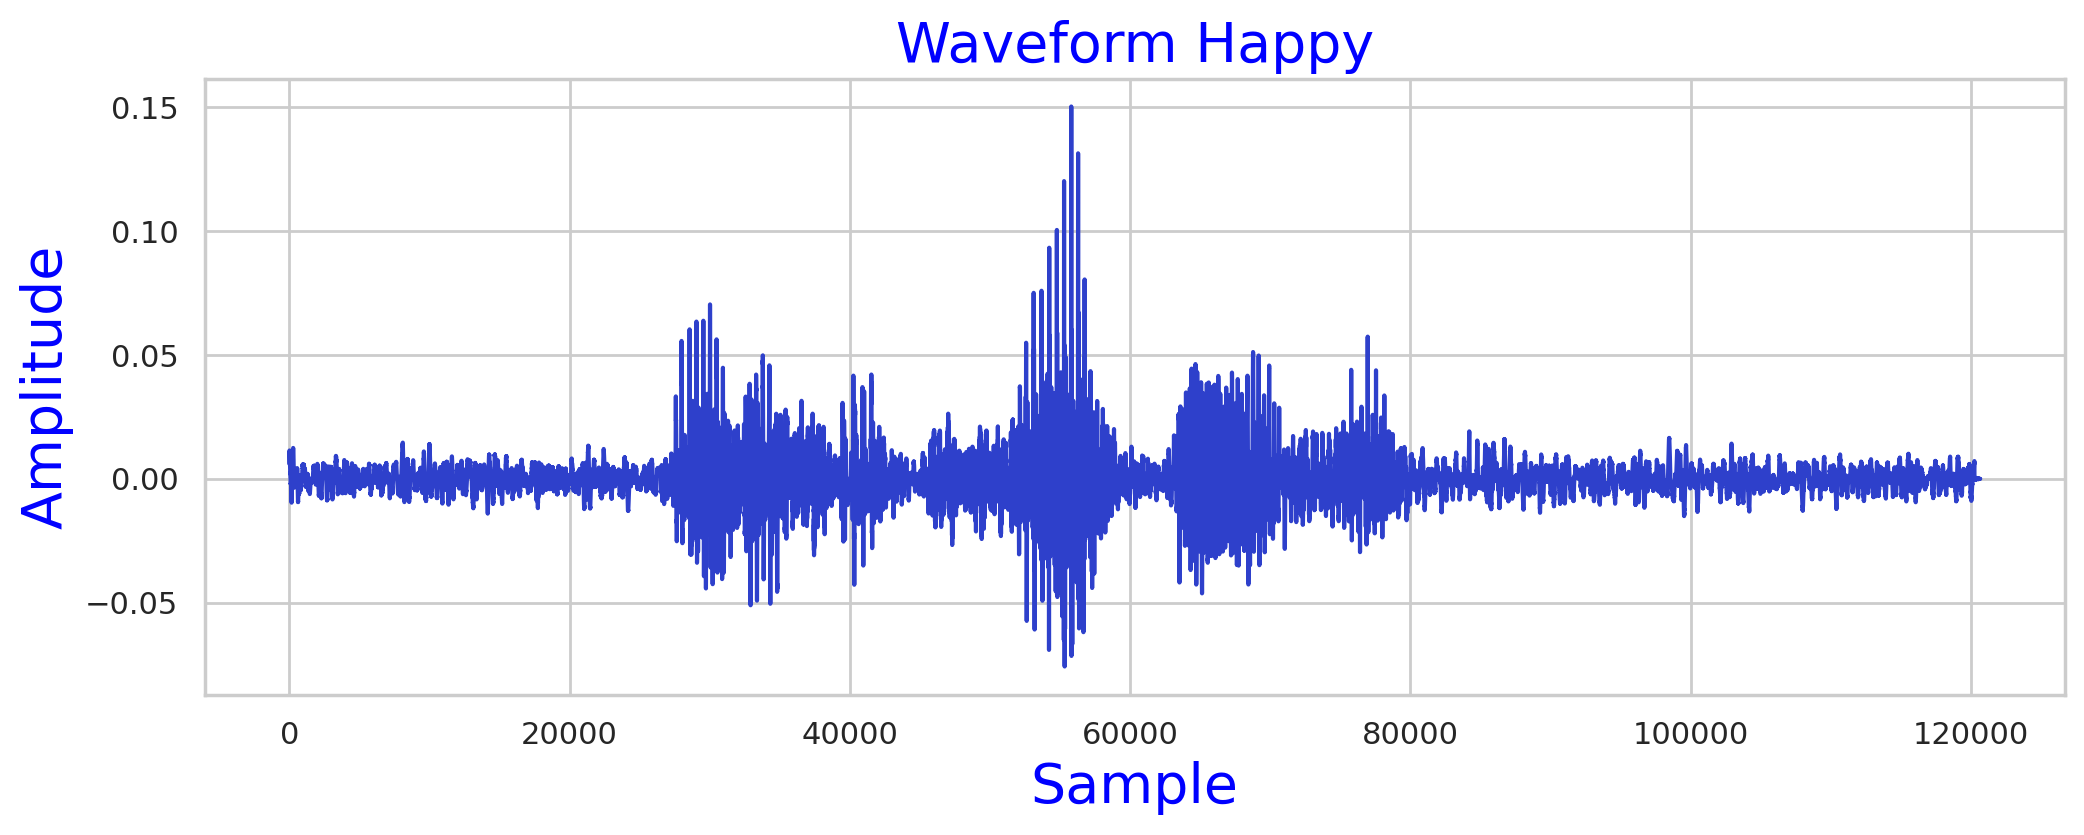

In [33]:
happy_sp = Sum_df_rep[Sum_df_rep['Emotions'] == 'happy']['Path']
happy_arr = Sum_df_rep[Sum_df_rep['Emotions'] == 'happy']['Arrays']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(happy_arr.iloc[0], color='#2E40CB')
plt.xlabel('Sample', fontdict= font2)
plt.ylabel('Amplitude', fontdict= font2)
plt.title('Waveform Happy', fontdict= font2)
plt.show()

Audio(happy_sp.iloc[0])

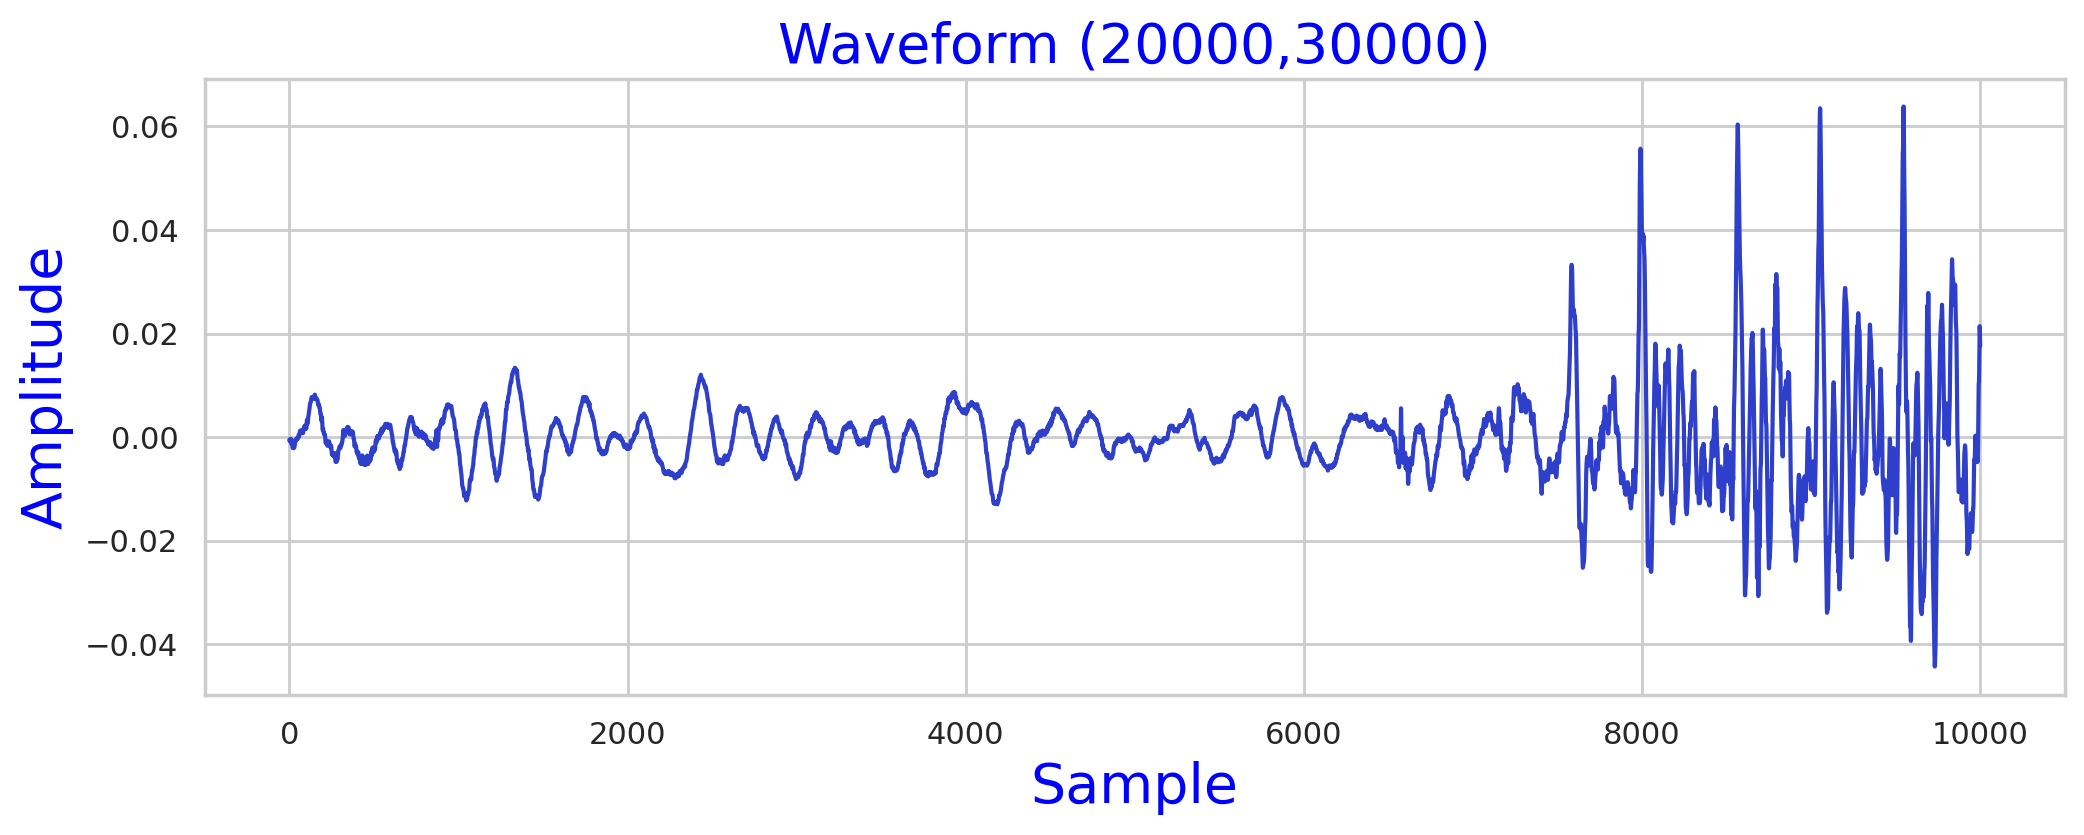

In [34]:
plt.figure(figsize=(12, 4), dpi=200)
plt.plot(happy_arr.iloc[0][20000:30000], color='#2E40CB')
plt.xlabel('Sample', fontdict= font2)
plt.ylabel('Amplitude', fontdict= font2)
plt.title('Waveform (20000,30000)', fontdict= font2)
plt.show()

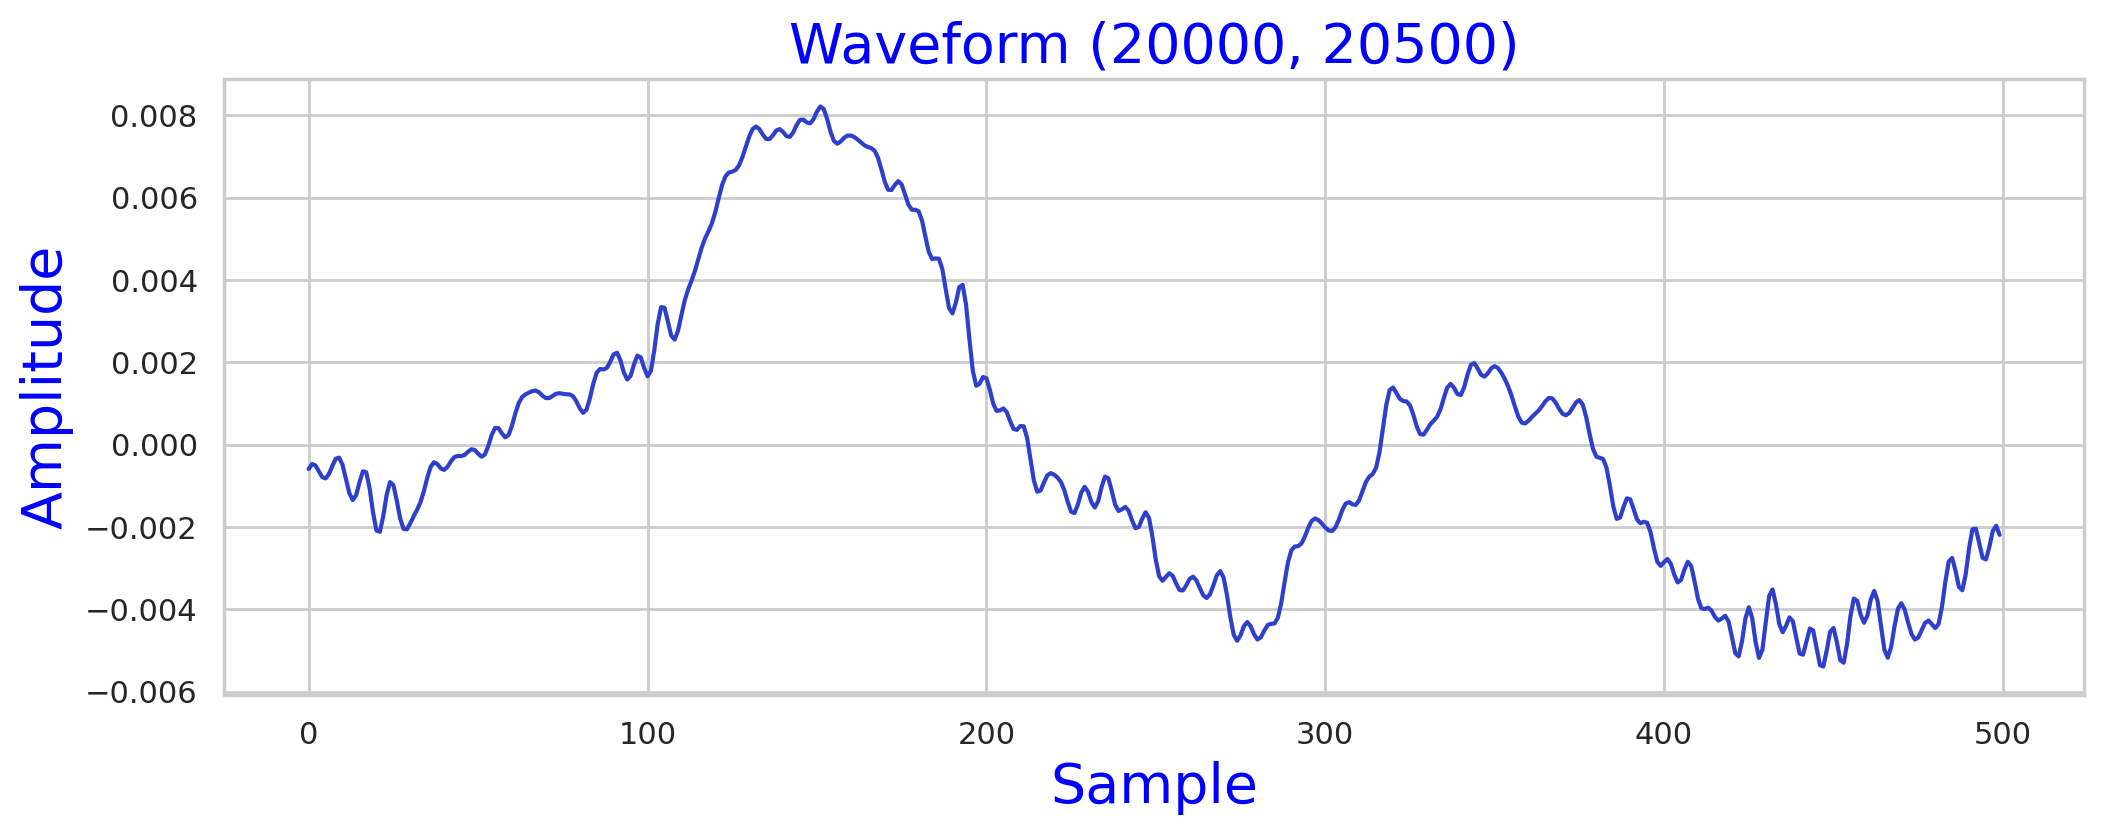

In [35]:
plt.figure(figsize=(12, 4), dpi=200)
plt.plot(happy_arr.iloc[0][20000:20500], color='#2E40CB')
plt.xlabel('Sample', fontdict= font2)
plt.ylabel('Amplitude', fontdict= font2)
plt.title('Waveform (20000, 20500)', fontdict= font2)
plt.show()

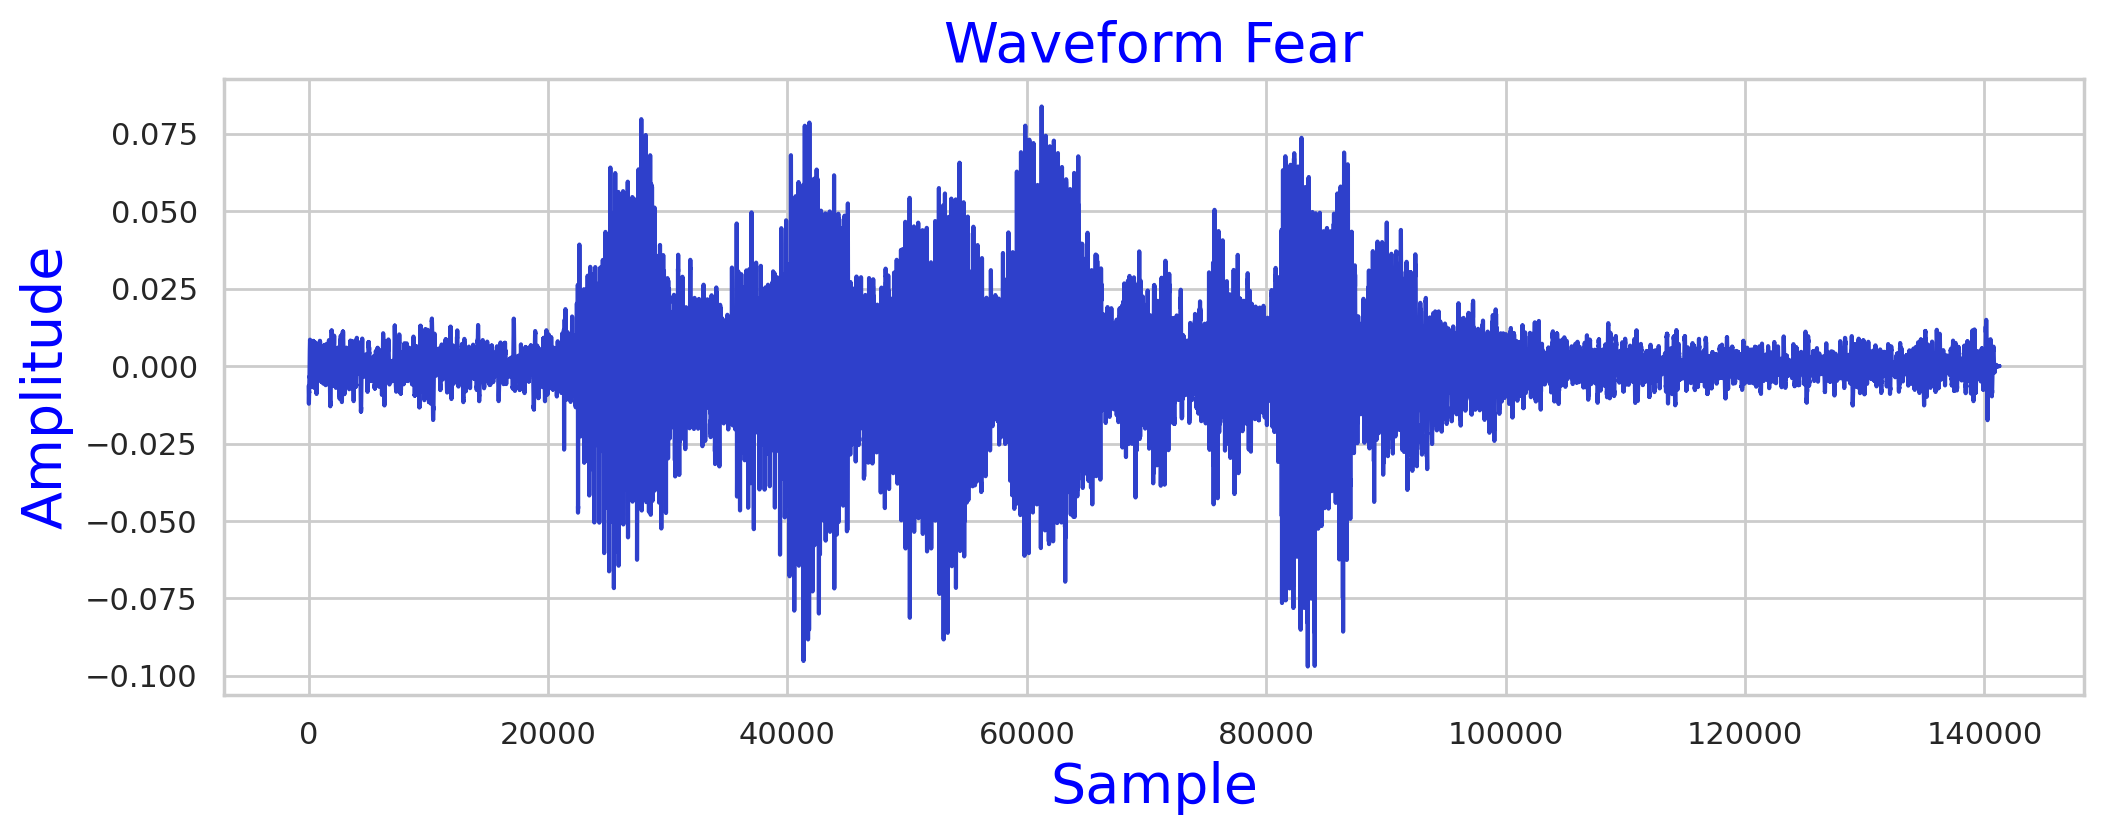

In [36]:
fear_sp = Sum_df_rep[Sum_df_rep['Emotions'] == 'fear']['Path']
fear_arr = Sum_df_rep[Sum_df_rep['Emotions'] == 'fear']['Arrays']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(fear_arr.iloc[0], color='#2E40CB')
plt.xlabel('Sample', fontdict= font2)
plt.ylabel('Amplitude', fontdict= font2)
plt.title('Waveform Fear', fontdict= font2)
plt.show()

Audio(fear_sp.iloc[0])

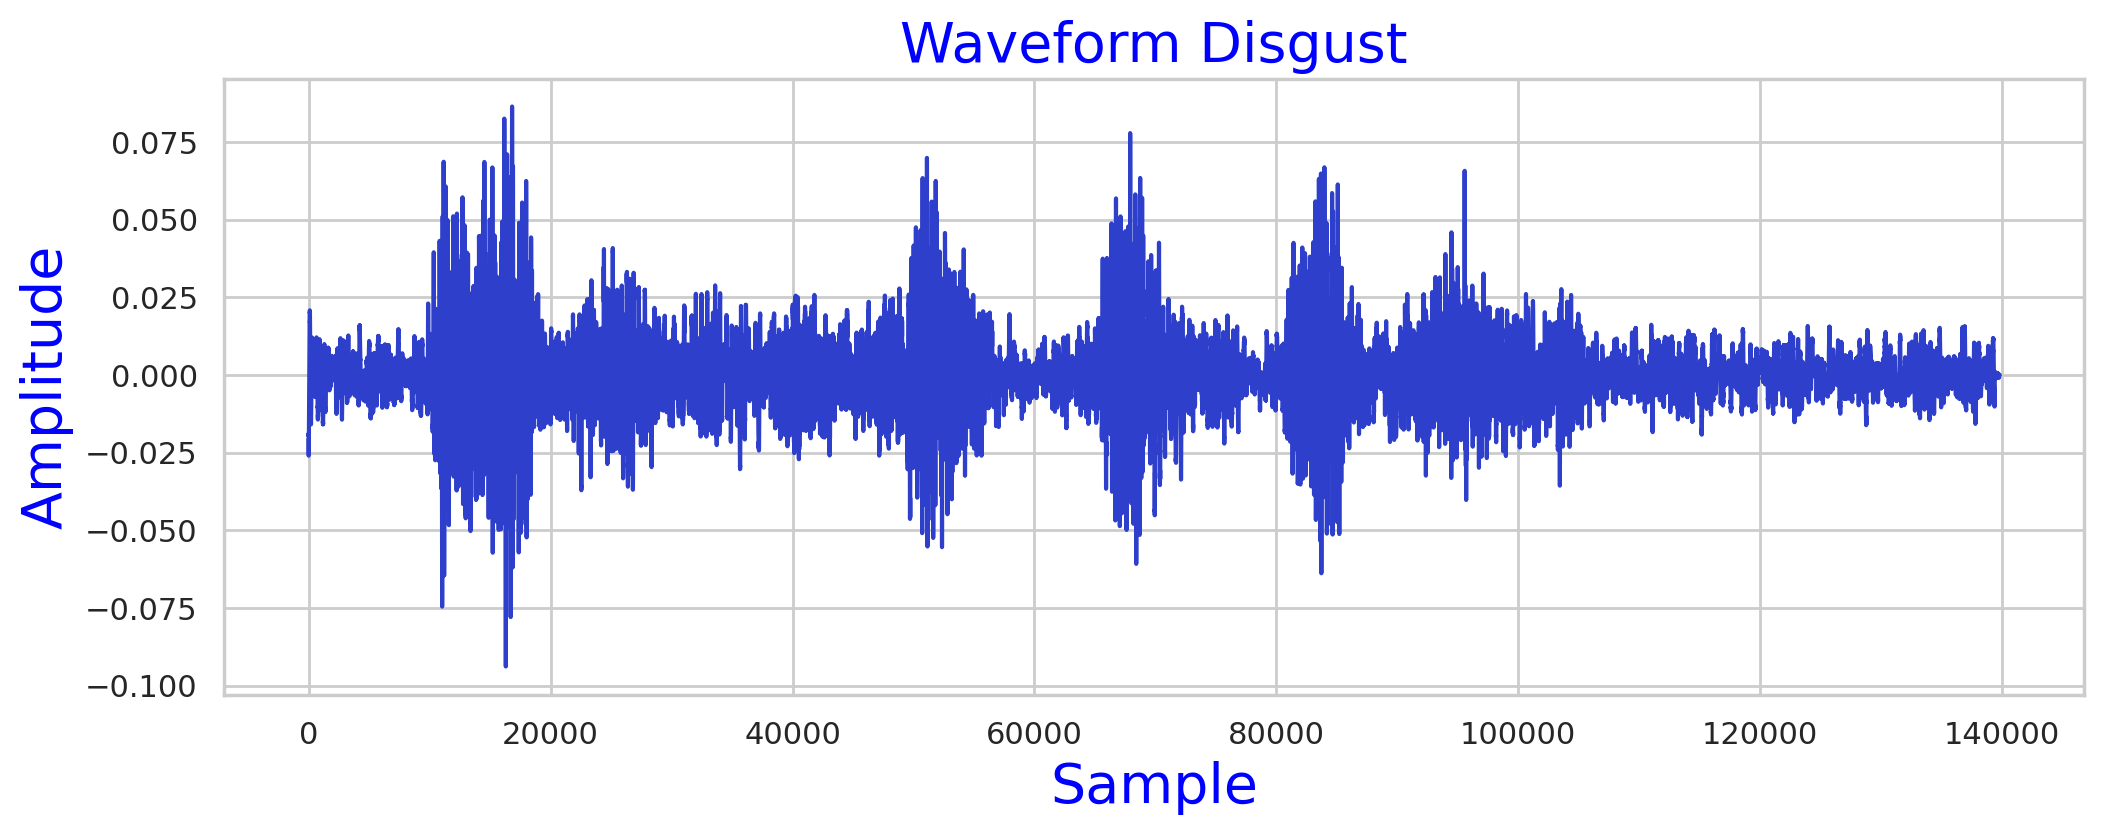

In [37]:
disgust_sp = Sum_df_rep[Sum_df_rep['Emotions'] == 'disgust']['Path']
disgust_arr = Sum_df_rep[Sum_df_rep['Emotions'] == 'disgust']['Arrays']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(disgust_arr.iloc[0], color='#2E40CB')
plt.xlabel('Sample', fontdict= font2)
plt.ylabel('Amplitude', fontdict= font2)
plt.title('Waveform Disgust', fontdict= font2)
plt.show()

Audio(disgust_sp.iloc[0])

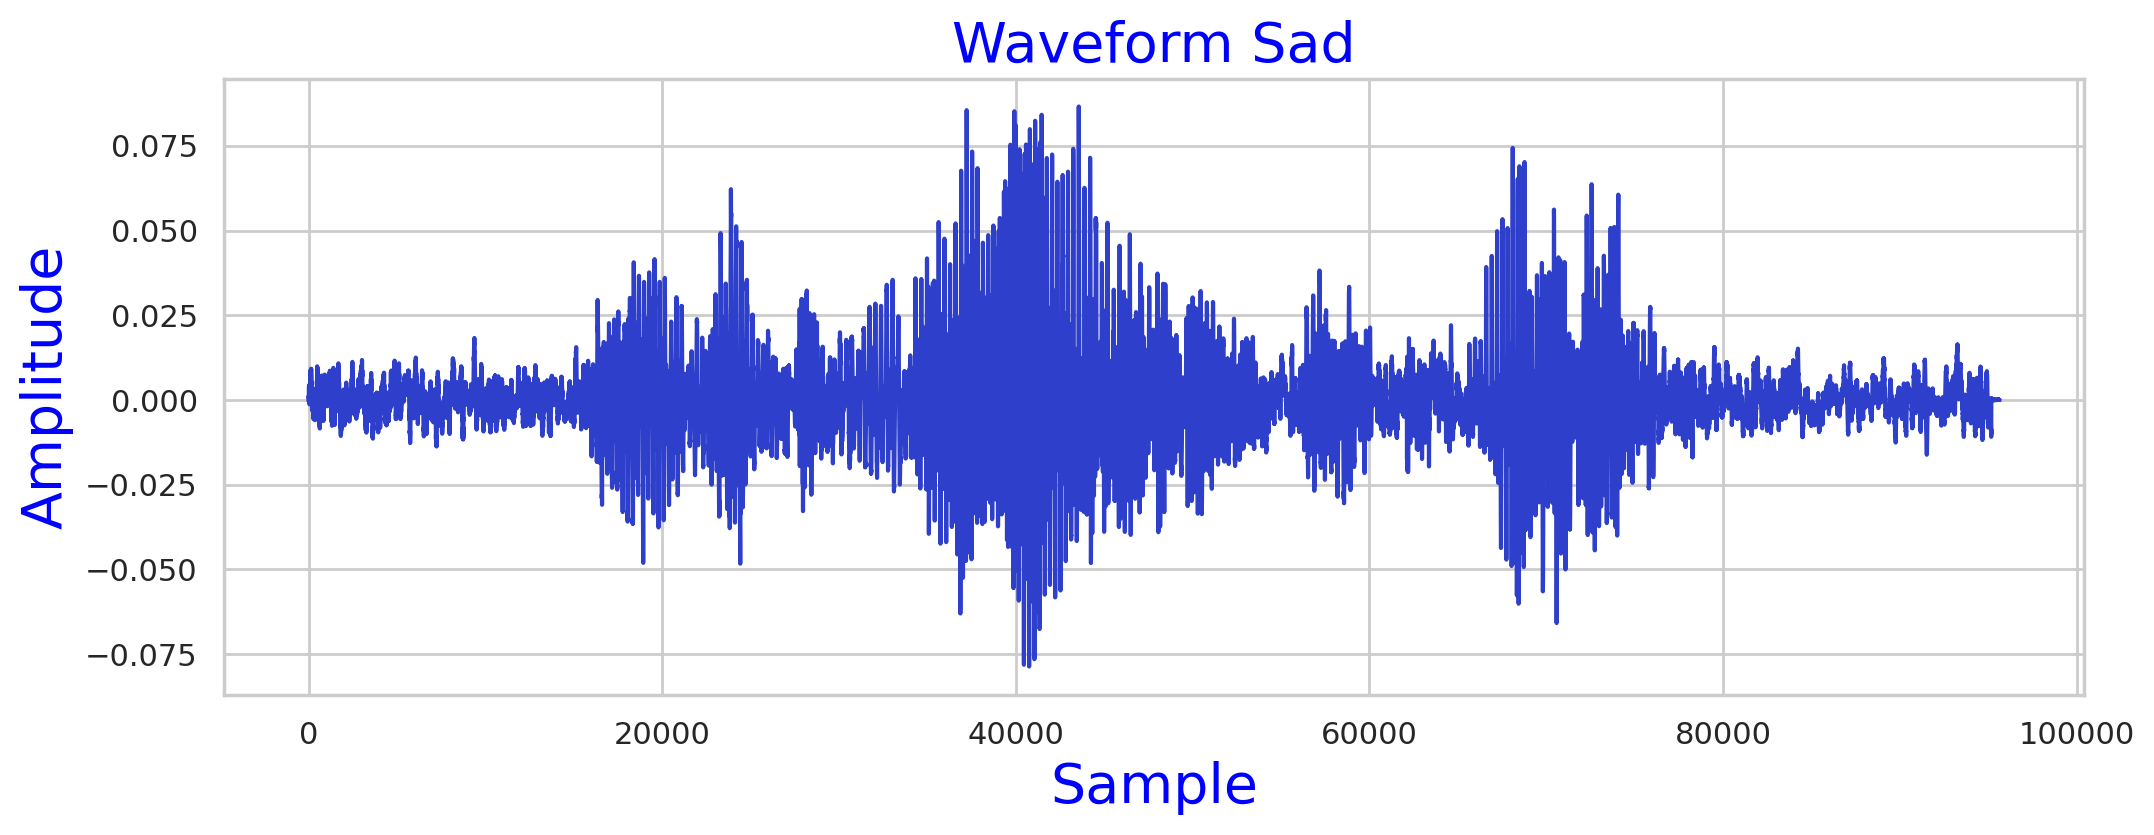

In [38]:
sad_sp = Sum_df_rep[Sum_df_rep['Emotions'] == 'sad']['Path']
sad_arr = Sum_df_rep[Sum_df_rep['Emotions'] == 'sad']['Arrays']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(sad_arr.iloc[0], color='#2E40CB')
plt.xlabel('Sample', fontdict= font2)
plt.ylabel('Amplitude', fontdict= font2)
plt.title('Waveform Sad', fontdict= font2)
plt.show()

Audio(sad_sp.iloc[0])

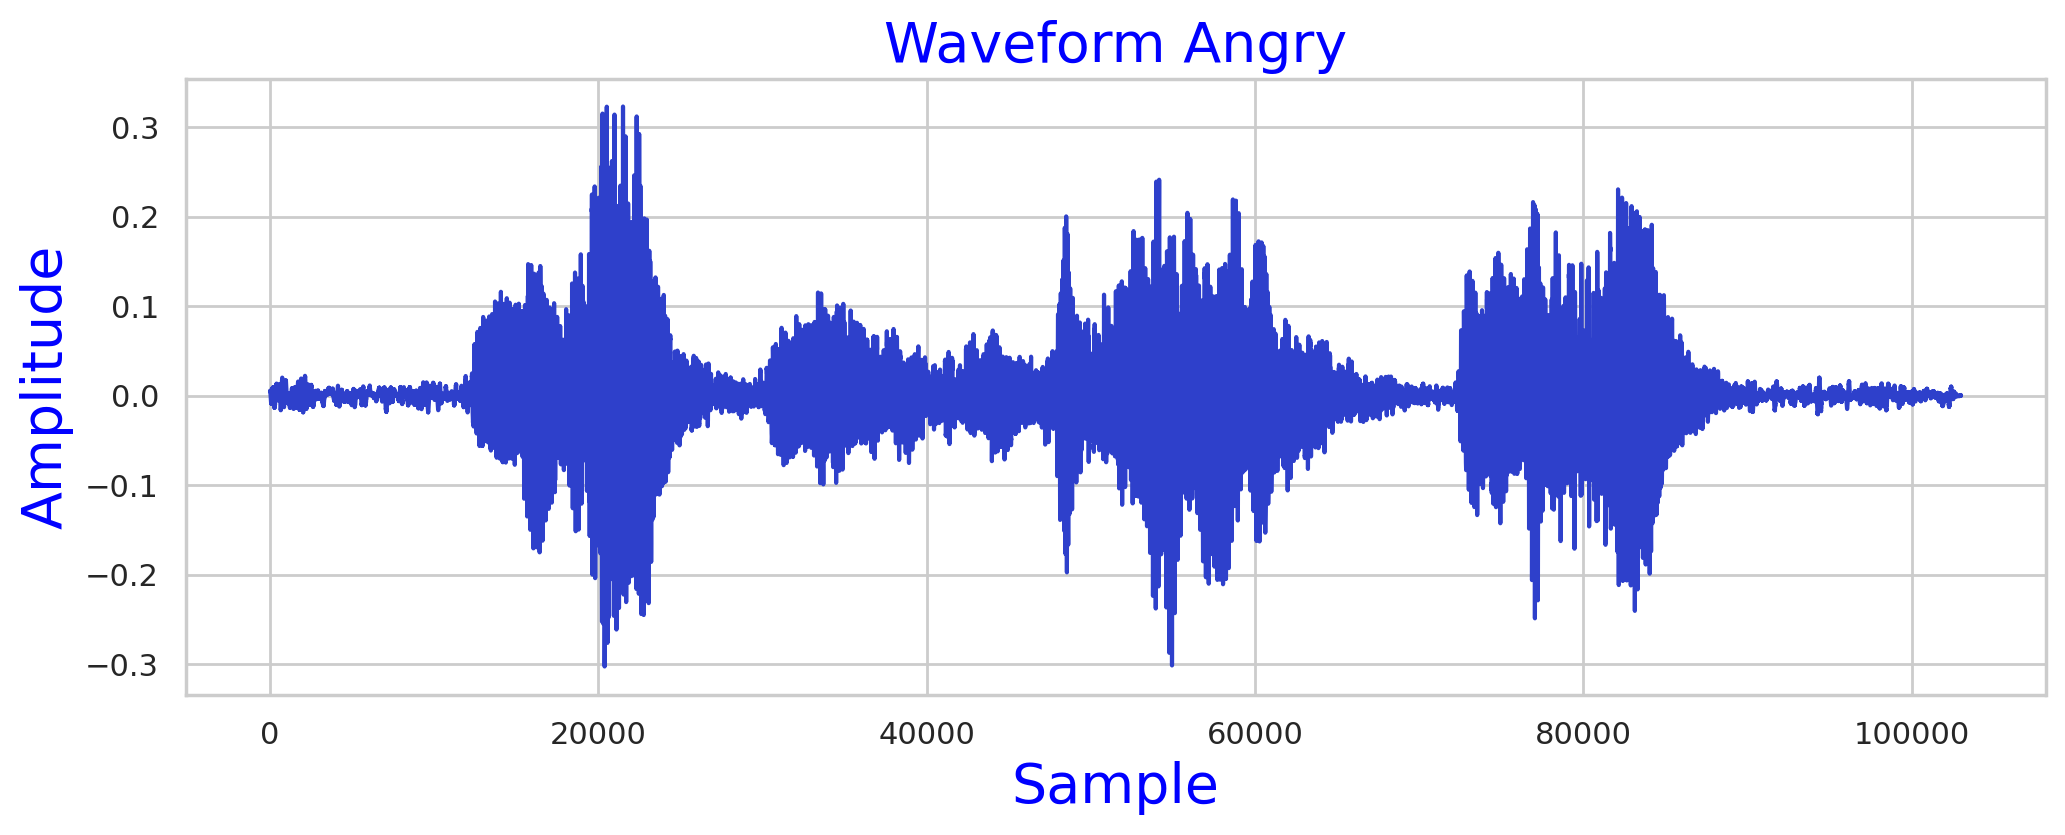

In [39]:
angry_sp = Sum_df_rep[Sum_df_rep['Emotions'] == 'angry']['Path']
angry_arr = Sum_df_rep[Sum_df_rep['Emotions'] == 'angry']['Arrays']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(angry_arr.iloc[0], color='#2E40CB')
plt.xlabel('Sample', fontdict= font2)
plt.ylabel('Amplitude', fontdict= font2)
plt.title('Waveform Angry', fontdict= font2)
plt.show()

Audio(angry_sp.iloc[0])

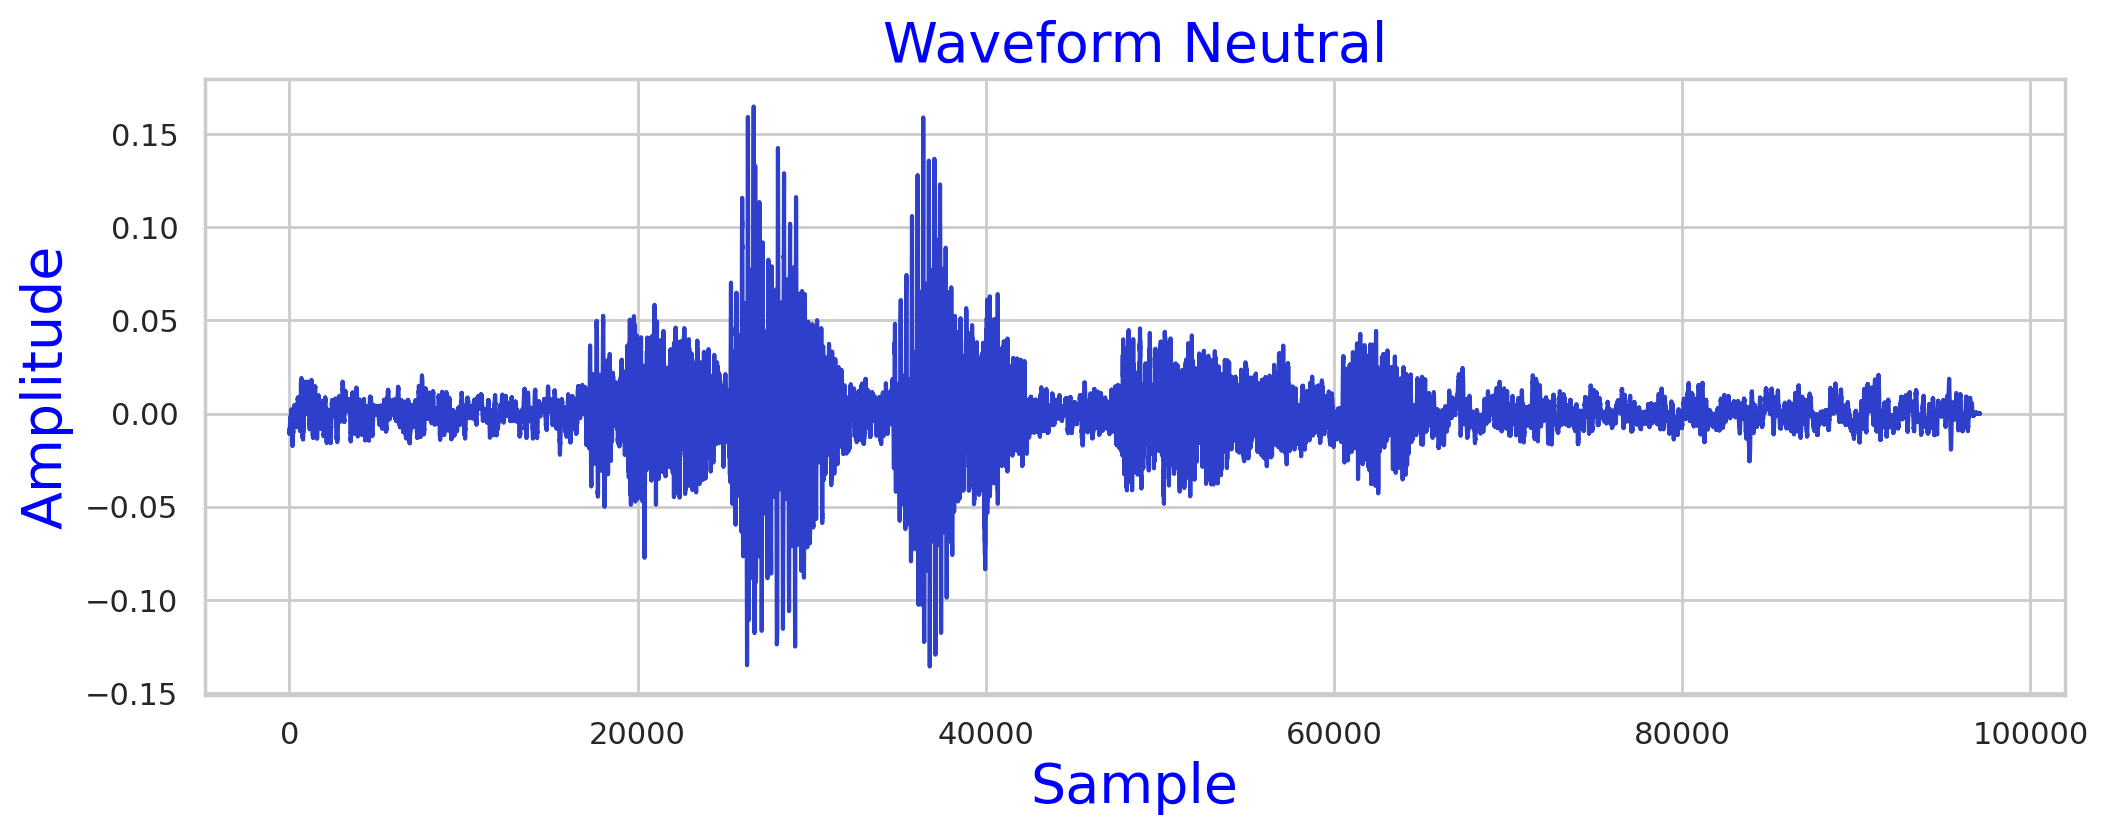

In [40]:
neutral_sp = Sum_df_rep[Sum_df_rep['Emotions'] == 'neutral']['Path']
neutral_arr = Sum_df_rep[Sum_df_rep['Emotions'] == 'neutral']['Arrays']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(neutral_arr.iloc[0], color='#2E40CB')
plt.xlabel('Sample', fontdict= font2)
plt.ylabel('Amplitude', fontdict= font2)
plt.title('Waveform Neutral', fontdict= font2)
plt.show()

Audio(neutral_sp.iloc[0])

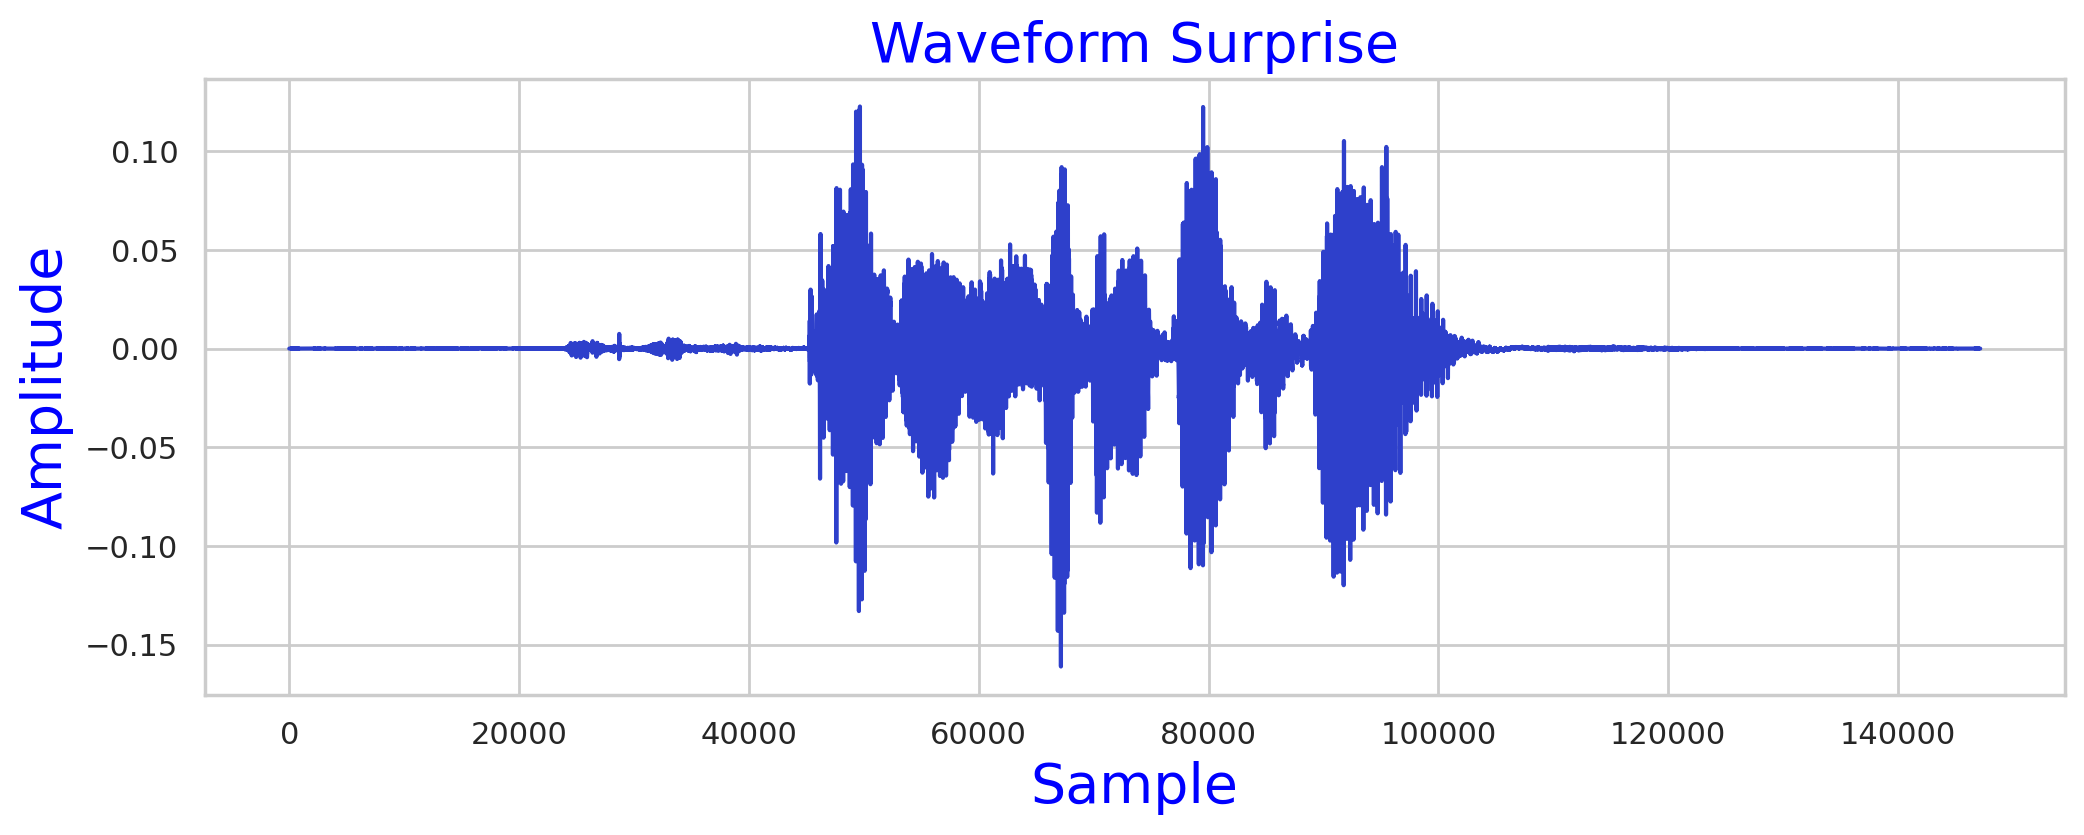

In [41]:
surprise_sp = Sum_df_rep[Sum_df_rep['Emotions'] == 'surprise']['Path']
surprise_arr = Sum_df_rep[Sum_df_rep['Emotions'] == 'surprise']['Arrays']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(surprise_arr.iloc[0], color='#2E40CB')
plt.xlabel('Sample', fontdict= font2)
plt.ylabel('Amplitude', fontdict= font2)
plt.title('Waveform Surprise', fontdict= font2)
plt.show()

Audio(surprise_sp.iloc[0])

In [42]:
sample_duration = 1/sr
print(sample_duration)

2.2675736961451248e-05


In [43]:
0#duration of the audio signals in seconds
duration = sample_duration * len(audio_arrays)
print(f"Duration of signal is: {duration:.2f} seconds")

Duration of signal is: 0.28 seconds


In [44]:
Frame_size = 1024
#HOP =  Current frame how many samples shift to the right for calculating the next frame
Hop_lenght = 512

#calculate the amplitude envelope

def amplitude_env (signal, frame_size, hop_length):
    amplitude_envelope = []

    #calculate AE (Amp Env) for each frame
    for i in range (0, len(signal), hop_length):
        current_frame_amplitude_env = max(signal[i:i+frame_size])
        amplitude_envelope.append(current_frame_amplitude_env)

    return np.array(amplitude_envelope)


def fancy_amplitude_env (signal, frame_size, hop_length):

    return np.array([max(signal[i:i+frame_size]) for i in range(0, signal.size, hop_length)])

In [45]:
# Samples

Sp_fear = fear_arr.iloc[0]
Sp_disgust= disgust_arr.iloc[0]
Sp_happy= happy_arr.iloc[0]
Sp_sad = sad_arr.iloc[0]
Sp_neutral = neutral_arr.iloc[0]
Sp_angry = angry_arr.iloc[0]
Sp_surprise = surprise_arr.iloc[0]

In [46]:
AE_fear = amplitude_env(Sp_fear, Frame_size, Hop_lenght)
AE_disgust = amplitude_env(Sp_disgust, Frame_size, Hop_lenght)
AE_happy = amplitude_env(Sp_happy, Frame_size, Hop_lenght)
AE_sad = amplitude_env(Sp_sad, Frame_size, Hop_lenght)
AE_neutral = amplitude_env(Sp_neutral, Frame_size, Hop_lenght)
AE_angry = amplitude_env(Sp_angry, Frame_size, Hop_lenght)
AE_surprise = amplitude_env(Sp_surprise, Frame_size, Hop_lenght)

print(len(AE_fear), len(AE_disgust), len(AE_angry), len(AE_happy), len(AE_neutral),
     len(AE_surprise), len(AE_sad))


276 274 202 236 190 288 187


In [47]:
fancy_AE_fear = fancy_amplitude_env(Sp_fear, Frame_size, Hop_lenght)
fancy_AE_disgust = fancy_amplitude_env(Sp_disgust, Frame_size, Hop_lenght)
fancy_AE_happy = fancy_amplitude_env(Sp_happy, Frame_size, Hop_lenght)
fancy_AE_sad = fancy_amplitude_env(Sp_sad, Frame_size, Hop_lenght)
fancy_AE_neutral = fancy_amplitude_env(Sp_neutral, Frame_size, Hop_lenght)
fancy_AE_angry = fancy_amplitude_env(Sp_angry, Frame_size, Hop_lenght)
fancy_AE_surprise = fancy_amplitude_env(Sp_surprise, Frame_size, Hop_lenght)

print(len(fancy_AE_fear), len(fancy_AE_disgust), len(fancy_AE_angry),
      len(fancy_AE_happy), len(fancy_AE_neutral),
     len(fancy_AE_surprise), len(fancy_AE_sad))

276 274 202 236 190 288 187


In [48]:
(AE_fear == fancy_AE_fear).all()

True

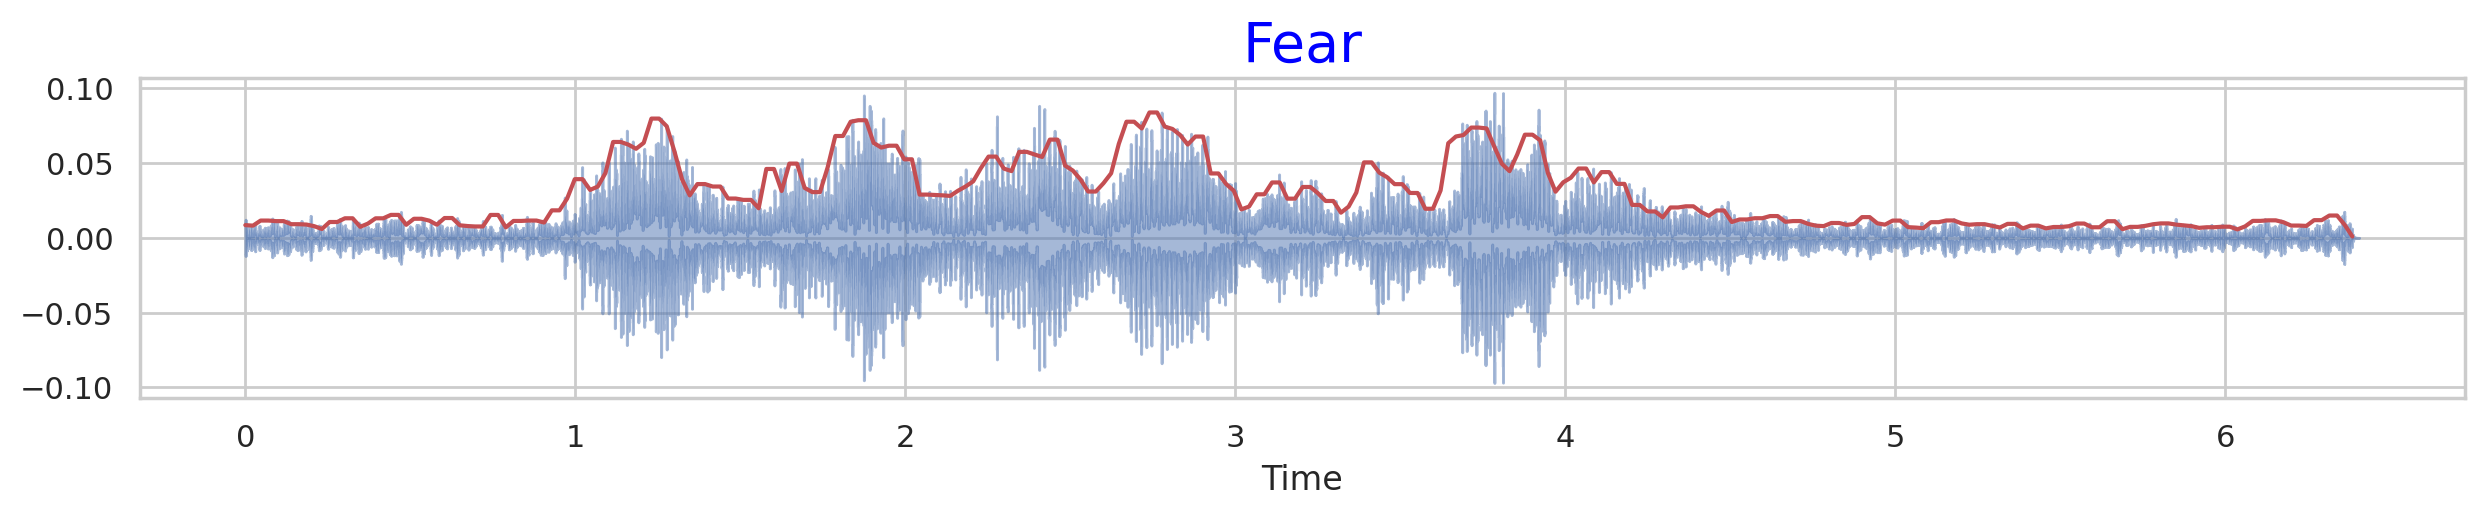

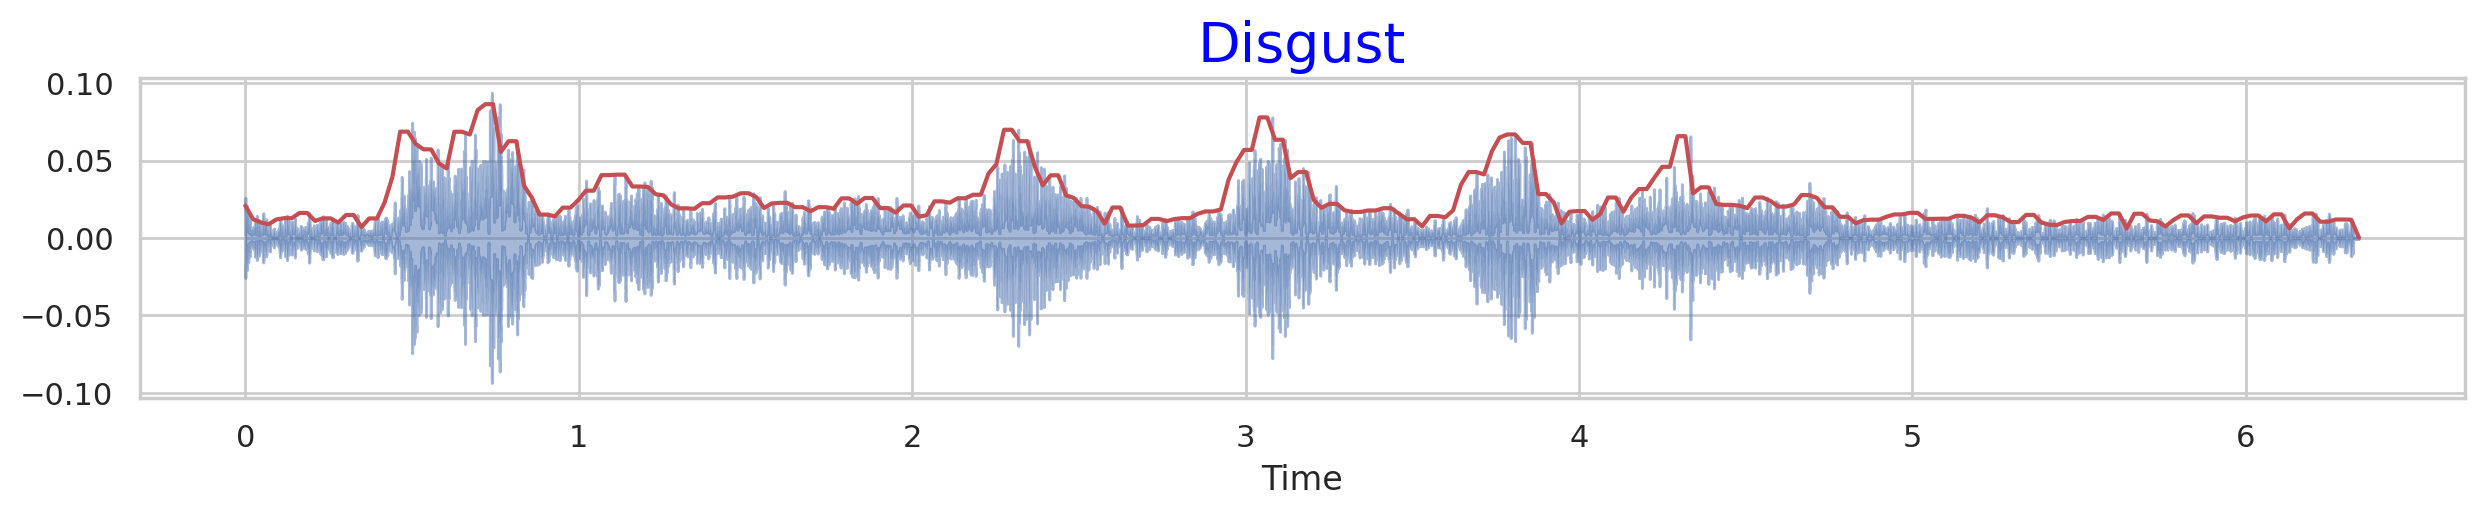

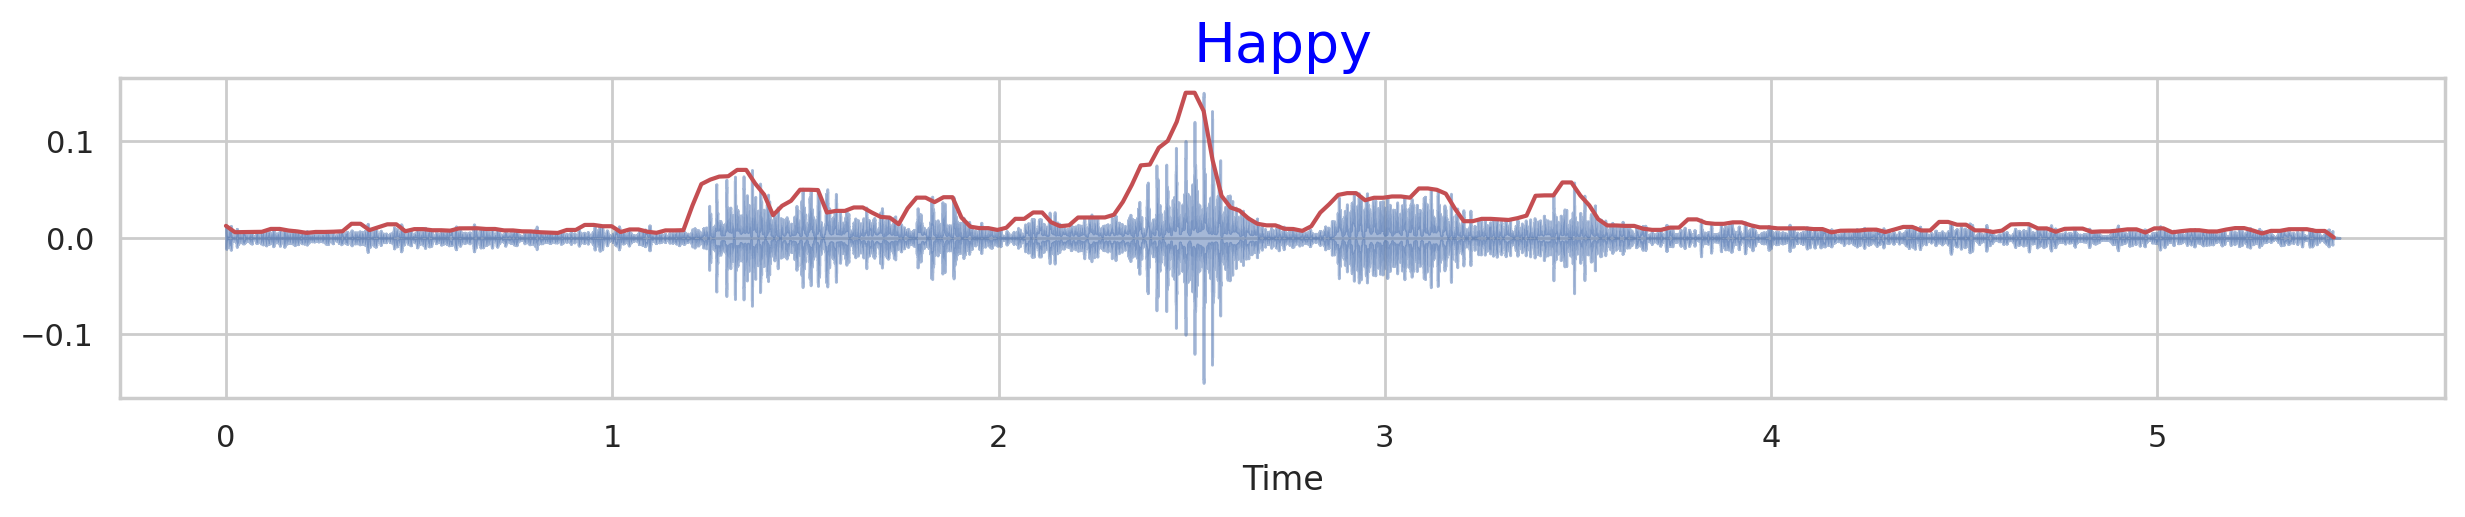

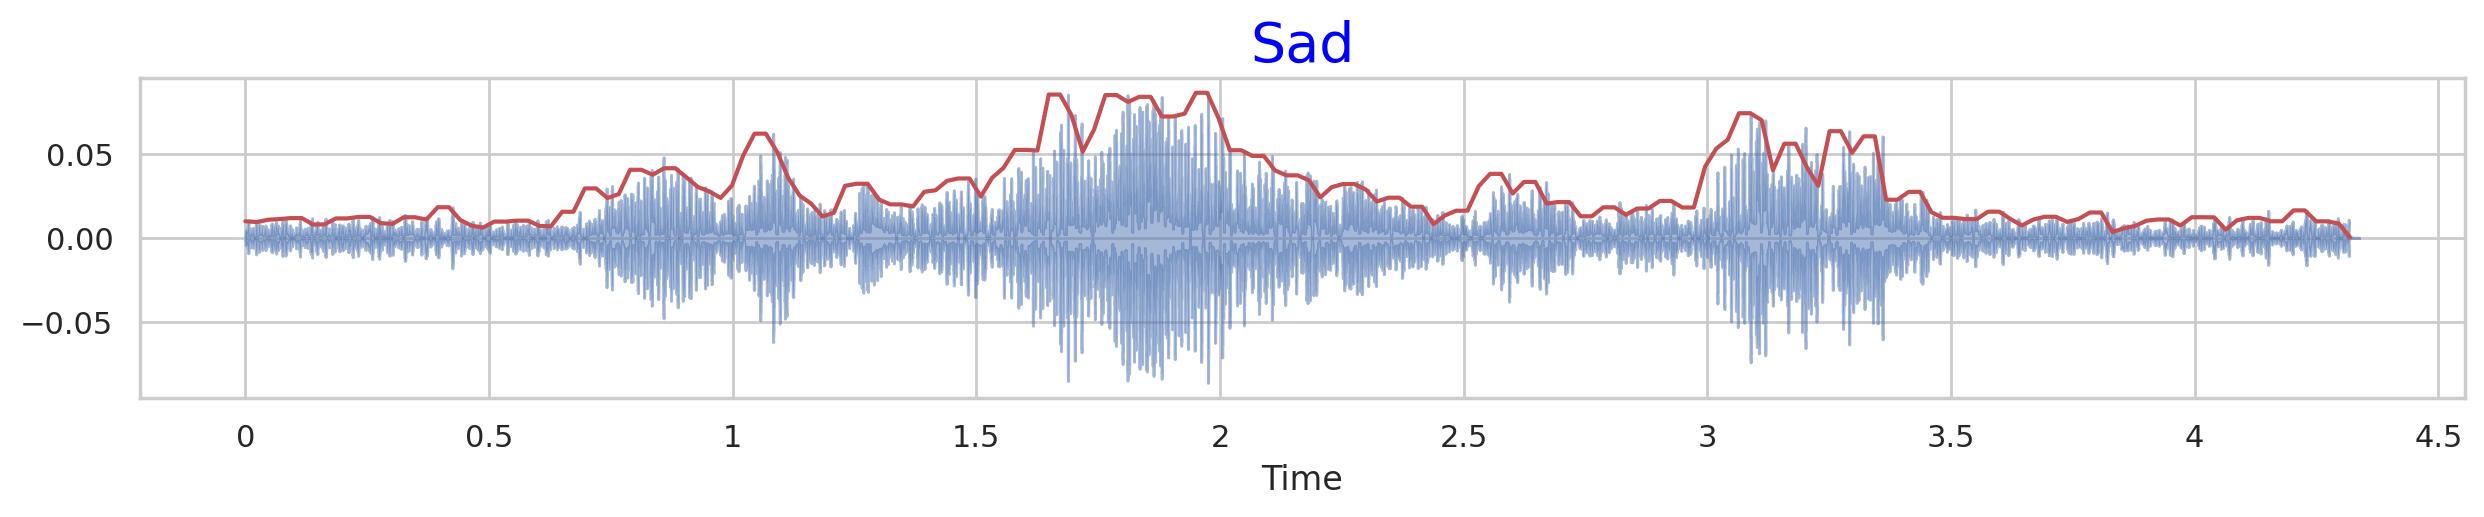

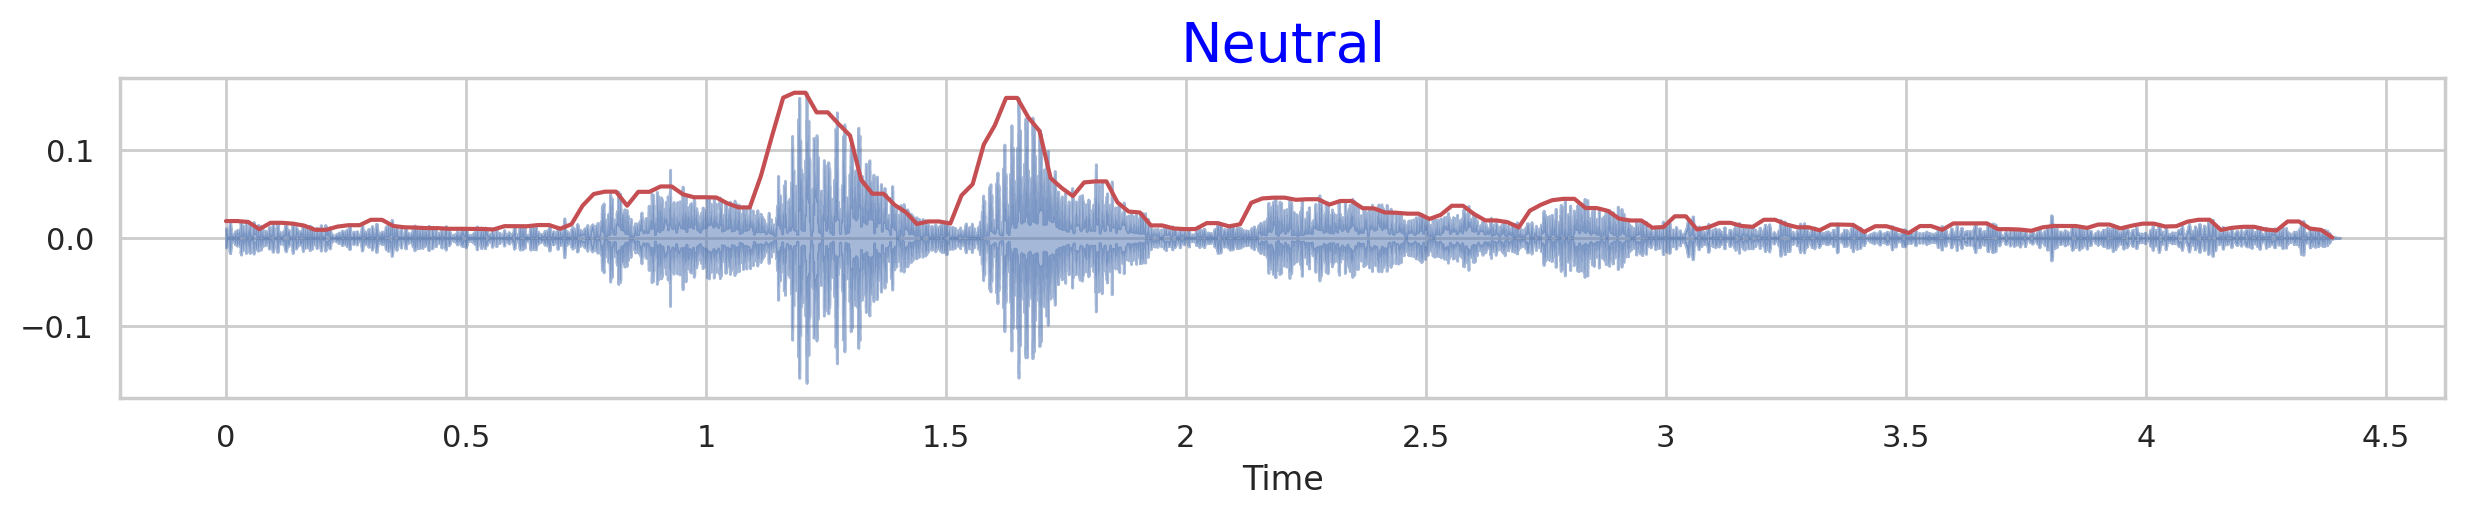

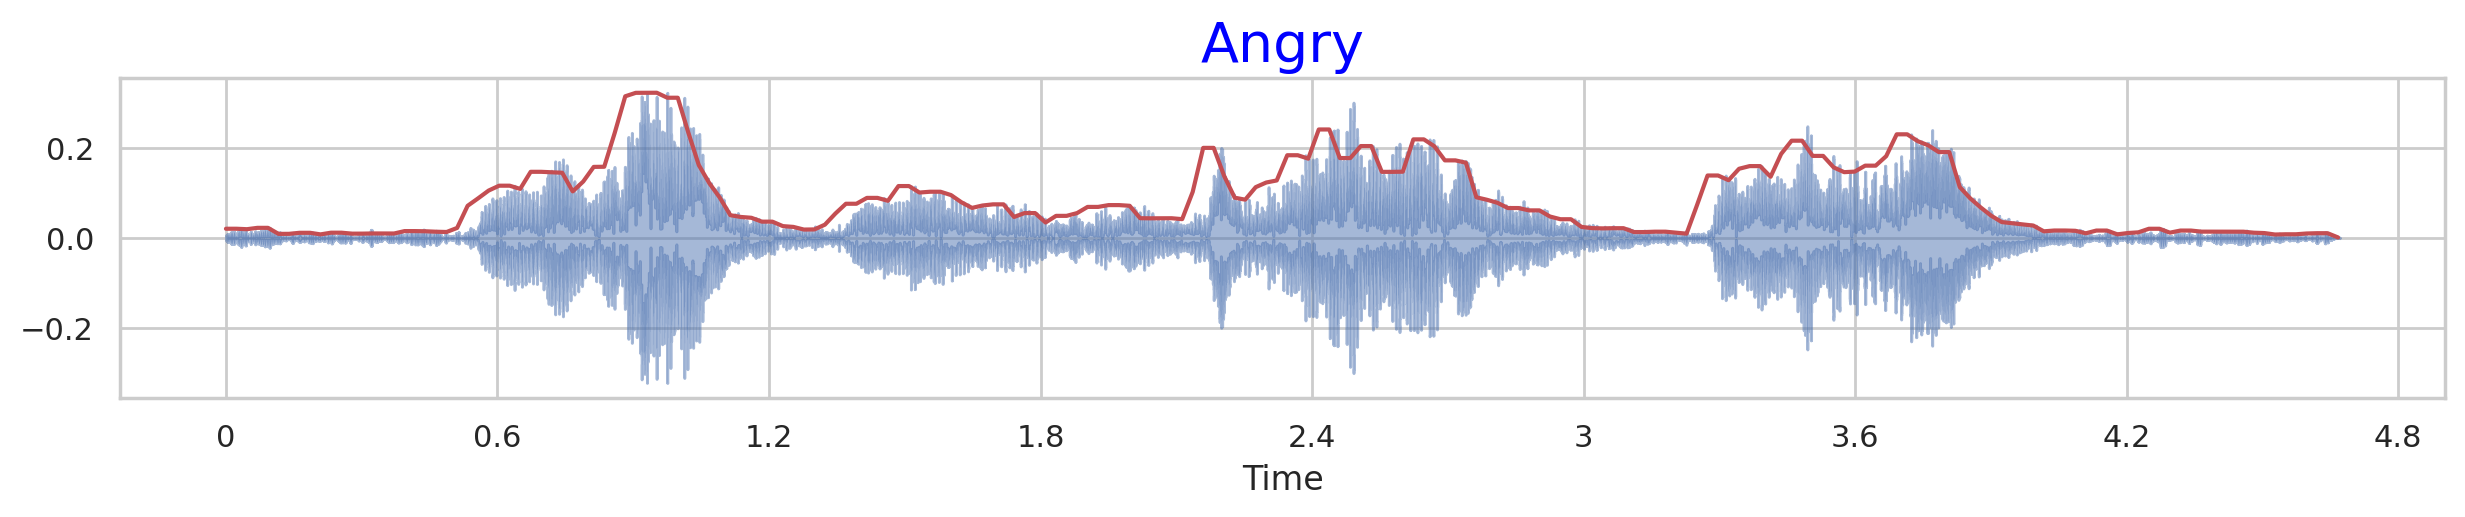

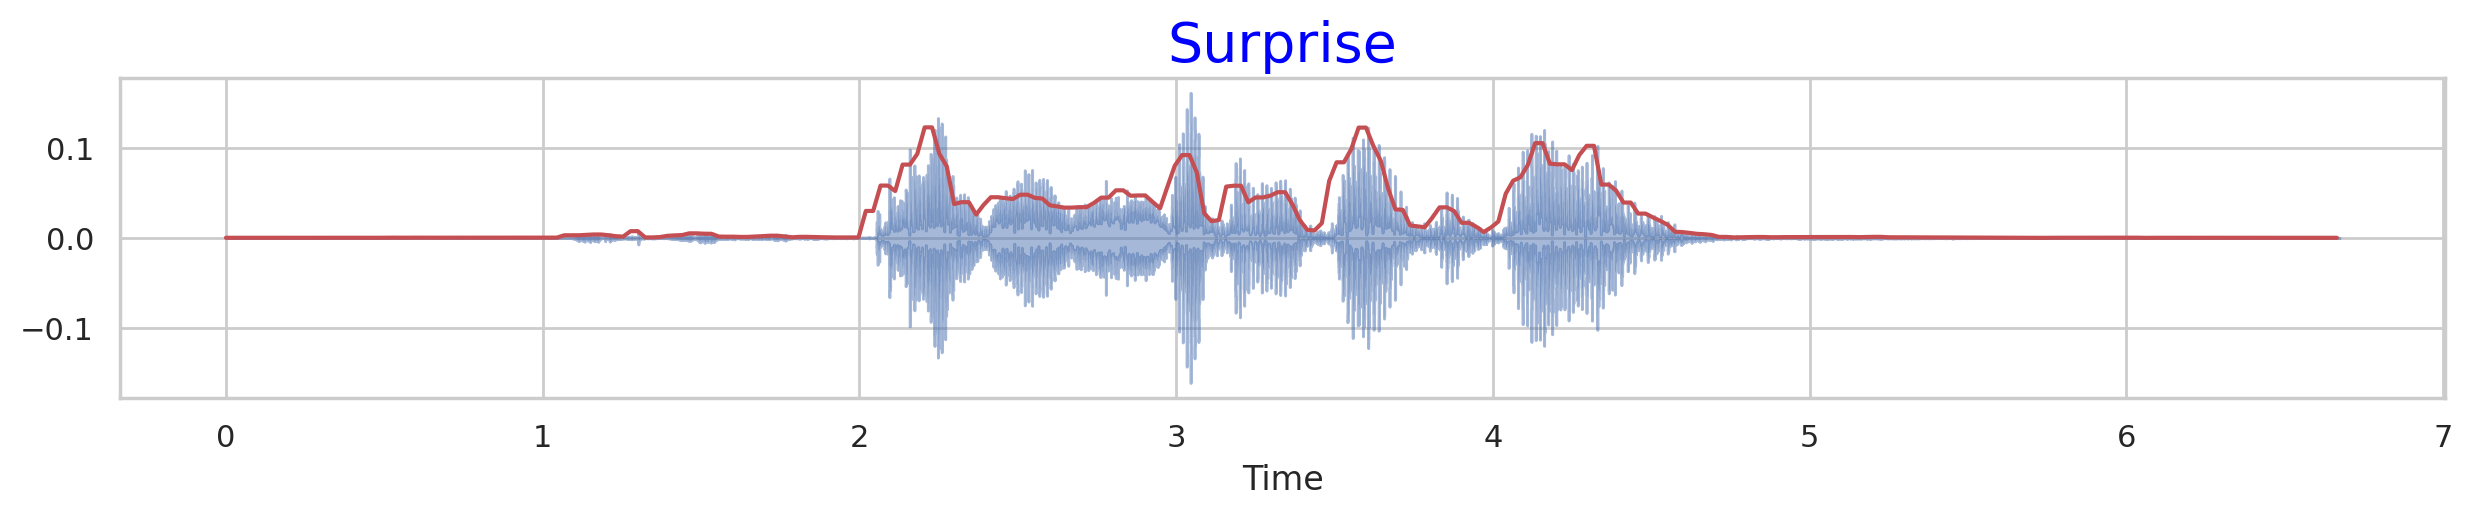

In [49]:
#Visualize amplitude envelope for all the audio files (Samples of each)

frames_fear = range(0, AE_fear.size)
frames_disgust = range(0, AE_disgust.size)
frames_happy = range(0, AE_happy.size)
frames_sad = range(0, AE_sad.size)
frames_neutral = range(0, AE_neutral.size)
frames_angry = range(0, AE_angry.size)
frames_surprise = range(0, AE_surprise.size)

t1 = librosa.frames_to_time(frames_fear, hop_length = Hop_lenght)
t2 = librosa.frames_to_time(frames_disgust, hop_length = Hop_lenght)
t3 = librosa.frames_to_time(frames_happy, hop_length = Hop_lenght)
t4 = librosa.frames_to_time(frames_sad, hop_length = Hop_lenght)
t5 = librosa.frames_to_time(frames_neutral, hop_length = Hop_lenght)
t6 = librosa.frames_to_time(frames_angry, hop_length = Hop_lenght)
t7 = librosa.frames_to_time(frames_surprise, hop_length = Hop_lenght)


plt.figure(figsize=(15,17), dpi=200)
plt.subplot(7,1,1)
librosa.display.waveshow(Sp_fear, alpha = 0.5)
plt.plot(t1, AE_fear, color = "r")
plt.title("Fear", fontdict= font2)
plt.show()

plt.figure(figsize=(15,17), dpi=200)
plt.subplot(7,1,2)
librosa.display.waveshow(Sp_disgust, alpha = 0.5)
plt.plot(t2, AE_disgust, color = "r")
plt.title("Disgust", fontdict= font2)
plt.show()

plt.figure(figsize=(15,17), dpi=200)
plt.subplot(7,1,3)
librosa.display.waveshow(Sp_happy, alpha = 0.5)
plt.plot(t3, AE_happy, color = "r")
plt.title("Happy", fontdict= font2)
plt.show()

plt.figure(figsize=(15,17), dpi=200)
plt.subplot(7,1,4)
librosa.display.waveshow(Sp_sad, alpha = 0.5)
plt.plot(t4, AE_sad, color = "r")
plt.title("Sad", fontdict= font2)
plt.show()


plt.figure(figsize=(15,17), dpi=200)
plt.subplot(7,1,5)
librosa.display.waveshow(Sp_neutral, alpha = 0.5)
plt.plot(t5, AE_neutral, color = "r")
plt.title("Neutral", fontdict= font2)
plt.show()


plt.figure(figsize=(15,17), dpi=200)
plt.subplot(7,1,6)
librosa.display.waveshow(Sp_angry, alpha = 0.5)
plt.plot(t6, AE_angry, color = "r")
plt.title("Angry", fontdict= font2)
plt.show()


plt.figure(figsize=(15,17), dpi=200)
plt.subplot(7,1,7)
librosa.display.waveshow(Sp_surprise, alpha = 0.5)
plt.plot(t7, AE_surprise, color = "r")
plt.title("Surprise", fontdict= font2)
plt.show()

In [50]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data



def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)


# taking any example and checking for techniques.
path = np.array(Sum_df_rep.Path)[1]
data, sample_rate = librosa.load(path)

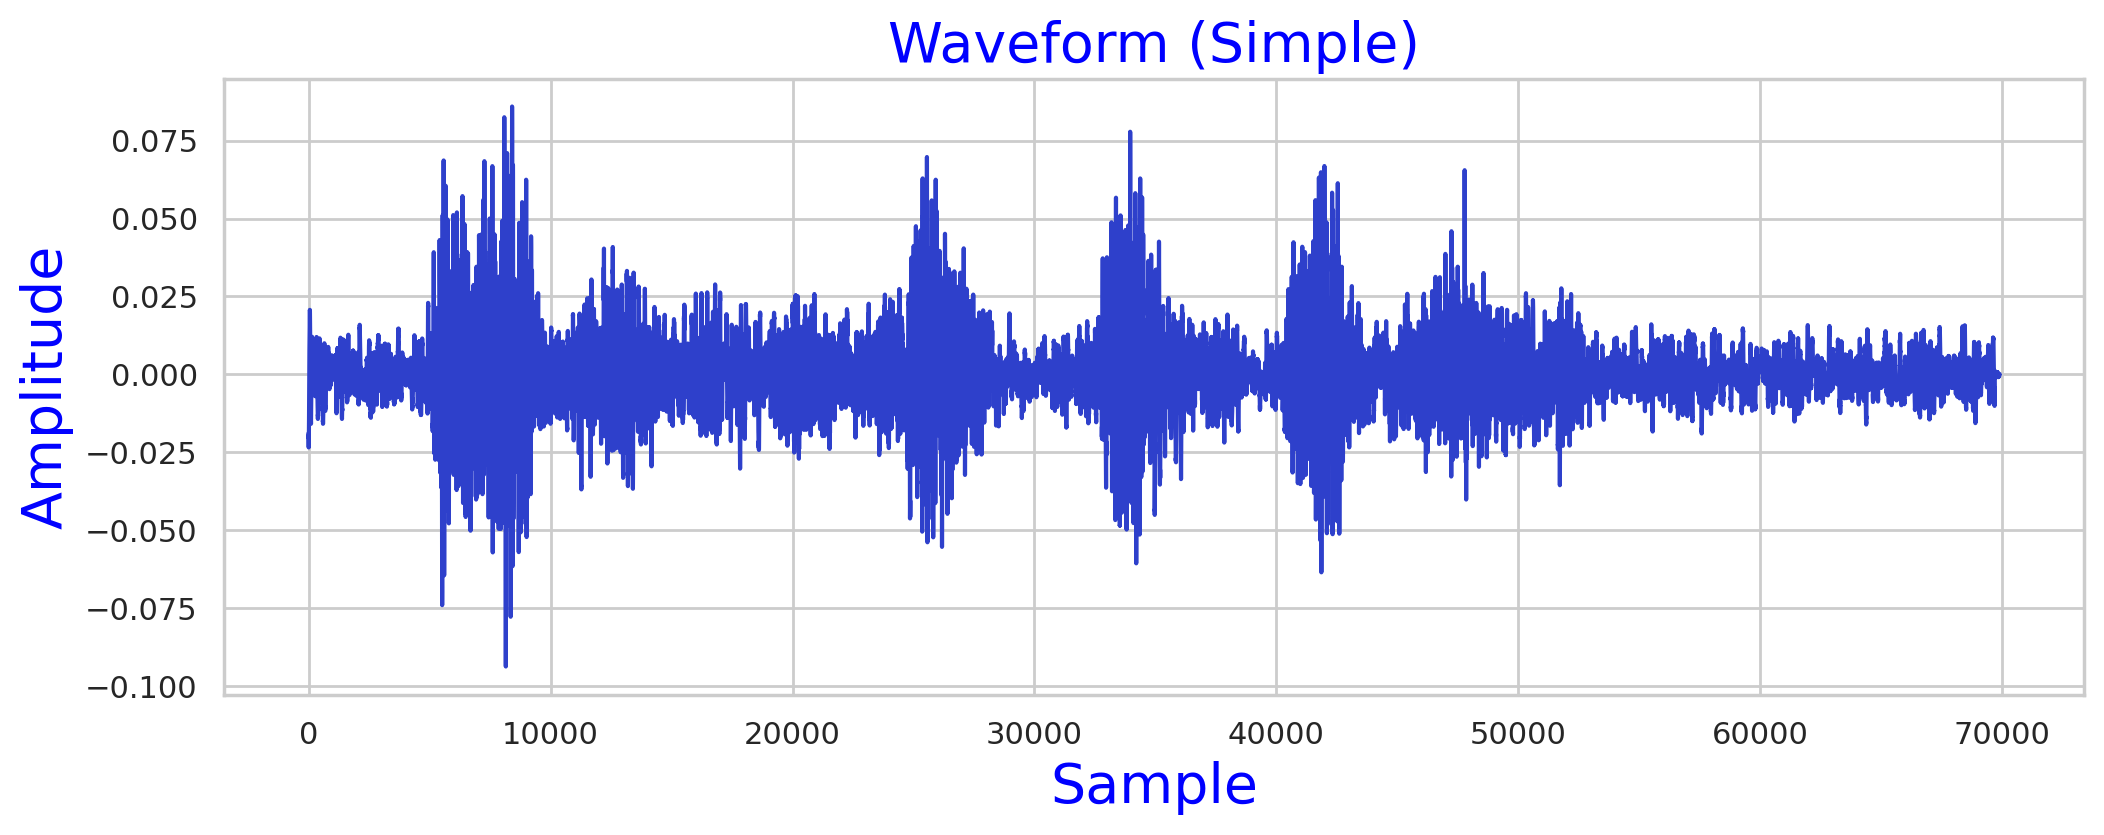

In [51]:
Simple_data = data
plt.figure(figsize=(12, 4), dpi=200)
plt.plot(Simple_data ,color='#2E40CB')
plt.xlabel('Sample', fontdict= font2)
plt.ylabel('Amplitude', fontdict= font2)
plt.title('Waveform (Simple)', fontdict= font2)
plt.show()

Audio(Simple_data, rate=sample_rate)

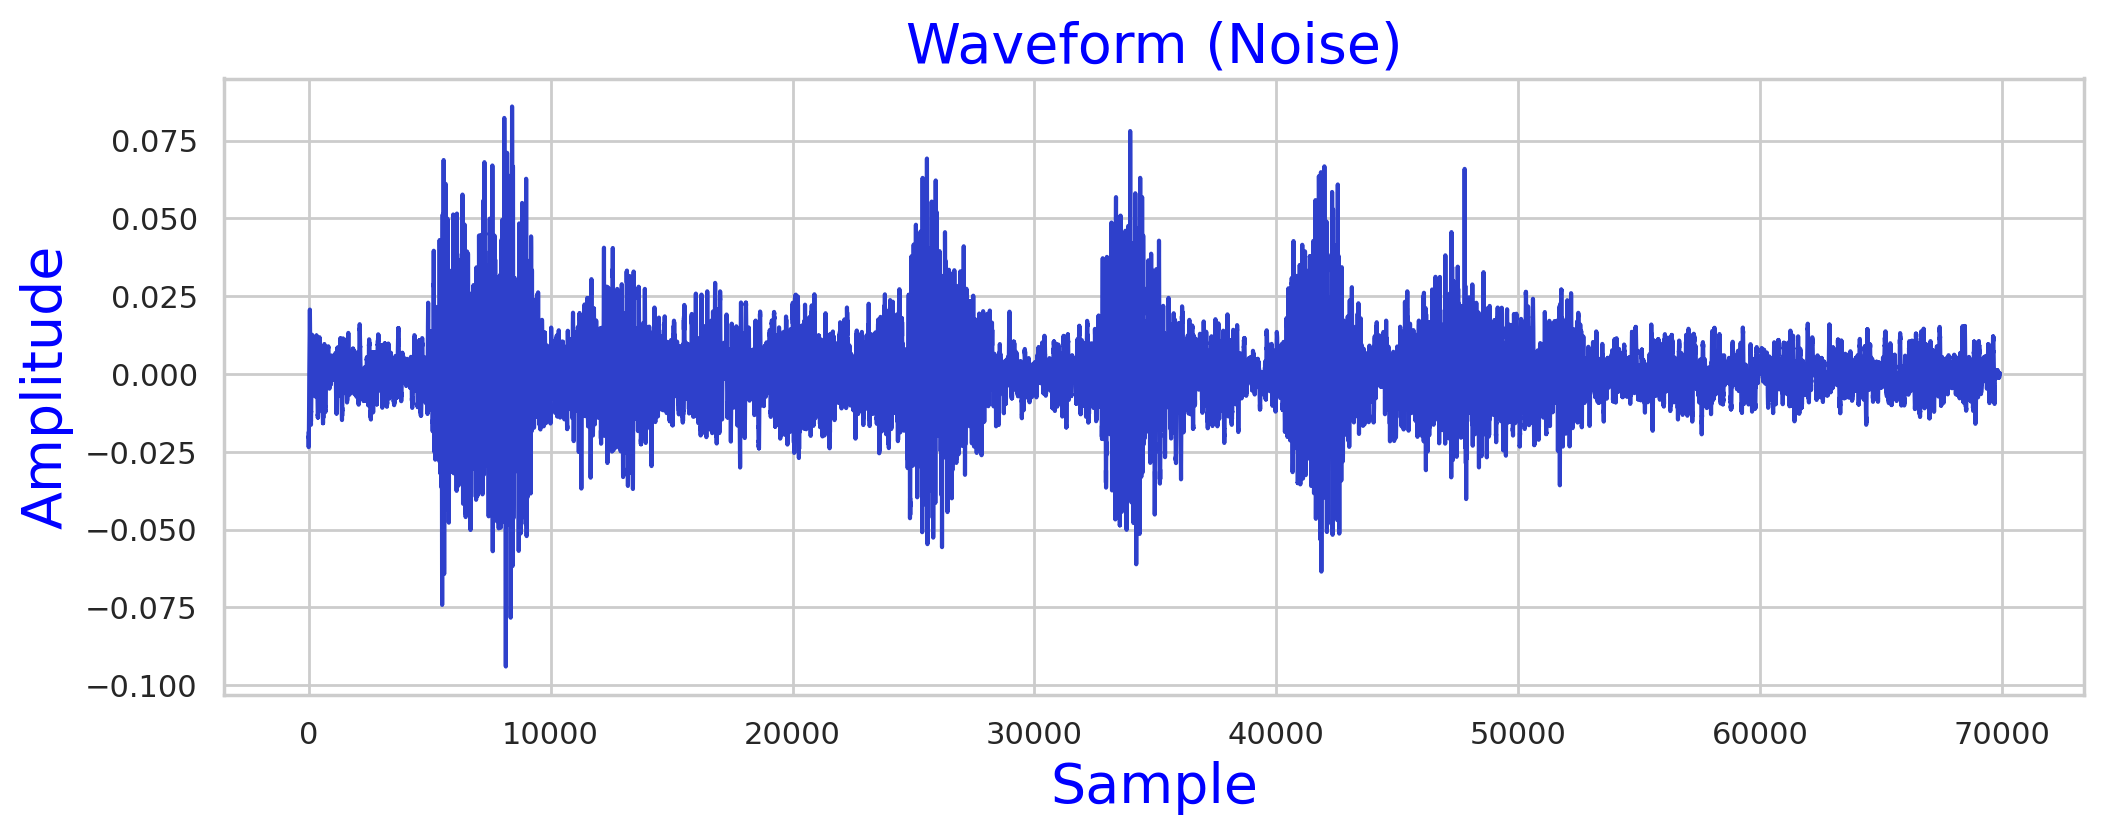

In [52]:
Noise_data = noise(data)
plt.figure(figsize=(12, 4), dpi=200)
plt.plot(Noise_data ,color='#2E40CB')
plt.xlabel('Sample', fontdict= font2)
plt.ylabel('Amplitude', fontdict= font2)
plt.title('Waveform (Noise)', fontdict= font2)
plt.show()

Audio(Noise_data, rate=sample_rate)

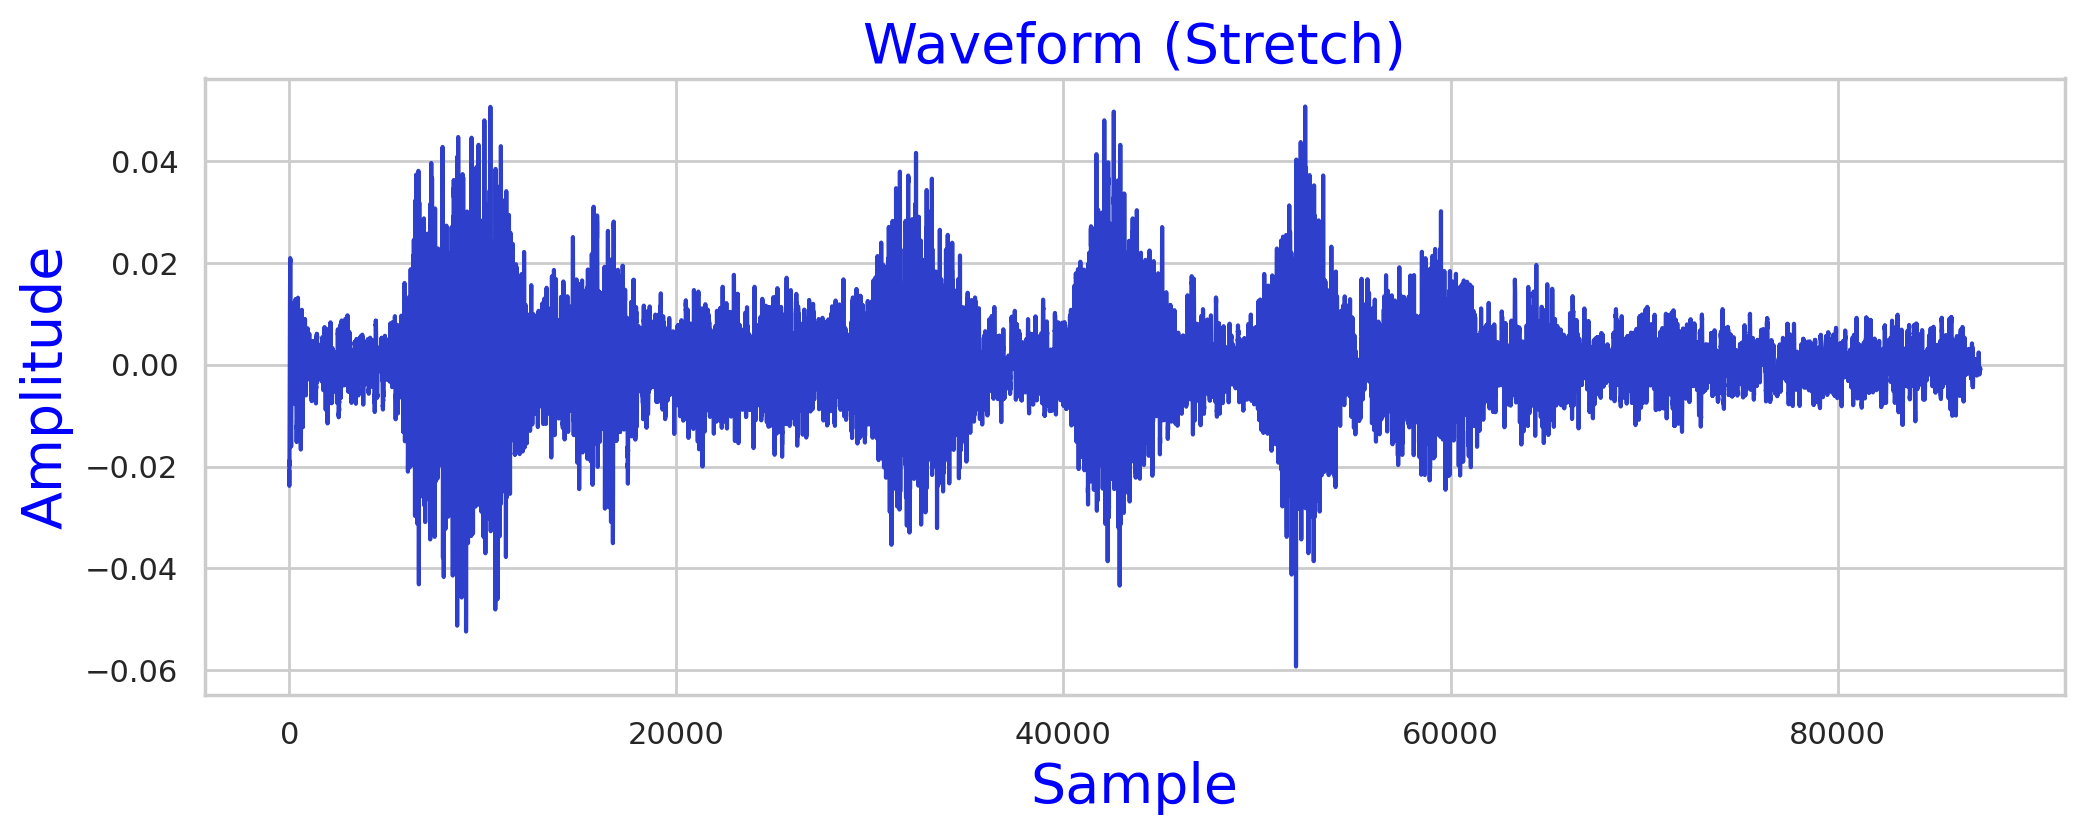

In [53]:
Stretch_data = stretch(data)
plt.figure(figsize=(12, 4), dpi=200)
plt.plot(Stretch_data ,color='#2E40CB')
plt.xlabel('Sample', fontdict= font2)
plt.ylabel('Amplitude', fontdict= font2)
plt.title('Waveform (Stretch)', fontdict= font2)
plt.show()

Audio(Stretch_data, rate=sample_rate)

* **[Table of Content](#0)**

<a id="5"></a>
# <p style="padding:10px;background-color:#0C4C79 ;margin:0;color:#ffffff;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Data PreParation </p>


In [ ]:
##Using only Crema dataset for recognition##

In [54]:
Crema_df

Emotions                                               Path
0     neutral  /kaggle/input/speech-emotion-recognition-en/Cr...
1     disgust  /kaggle/input/speech-emotion-recognition-en/Cr...
2       angry  /kaggle/input/speech-emotion-recognition-en/Cr...
3       angry  /kaggle/input/speech-emotion-recognition-en/Cr...
4         sad  /kaggle/input/speech-emotion-recognition-en/Cr...
...       ...                                                ...
7437     fear  /kaggle/input/speech-emotion-recognition-en/Cr...
7438      sad  /kaggle/input/speech-emotion-recognition-en/Cr...
7439    angry  /kaggle/input/speech-emotion-recognition-en/Cr...
7440  disgust  /kaggle/input/speech-emotion-recognition-en/Cr...
7441    happy  /kaggle/input/speech-emotion-recognition-en/Cr...

[7442 rows x 2 columns]

In [55]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration = 3, offset = 0.5)
    mfcc = np.mean(librosa.feature.mfcc(y = y, sr = sr, n_mfcc = 40).T, axis = 0)
    return mfcc

In [56]:
extract_mfcc(Crema_df['Path'][0])

array([-3.9827225e+02,  1.1269526e+02,  1.8745134e+01,  6.2886295e+01,
       -5.6198473e+00,  3.6359207e+01, -2.1924604e+01,  1.1621837e+01,
       -1.4005442e+01,  2.2792380e+00, -4.6413107e+00, -8.1988993e+00,
        7.0591068e+00, -1.1286680e+01,  5.7418375e+00, -8.8726530e+00,
        3.9861393e+00, -9.3758621e+00,  4.6381563e-01, -5.7474904e+00,
       -3.6675432e+00, -1.1239439e+00, -4.7588844e+00,  6.2277408e+00,
       -4.4725132e+00,  4.6909051e+00, -2.1200652e+00,  5.7708974e+00,
       -3.9611544e-02,  2.7335296e+00,  1.3543155e+00, -1.5225507e+00,
        4.0215826e+00, -1.9429311e+00,  2.5933967e+00, -1.4827572e+00,
        4.7985725e+00,  7.6043022e-01,  2.2850940e+00, -1.9845906e+00],
      dtype=float32)

In [57]:
%%time
X_mfcc = Crema_df['Path'].apply(lambda x: extract_mfcc(x))

CPU times: user 1min 28s, sys: 1min 9s, total: 2min 38s
Wall time: 1min 40s


In [58]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(7442, 40)

In [59]:
## input split
X = np.expand_dims(X, -1)
X.shape

(7442, 40, 1)

In [60]:
enc = OneHotEncoder()
y = enc.fit_transform(Crema_df[['Emotions']])

In [61]:
y = y.toarray()

<a id="6"></a>
# <p style="padding:10px;background-color:#0C4C79 ;margin:0;color:#ffffff;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">LSTM Model </p>


In [62]:
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
print(Iterable)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 3

In [63]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, Callback

# Define the checkpoint path
checkpoint_filepath = 'best_model.keras'

# Define the ModelCheckpoint callback
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# Define the LearningRateScheduler callback
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler_callback = LearningRateScheduler(scheduler)

# Custom callback to check if the model was saved
class CheckModelSavedCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if os.path.exists(checkpoint_filepath):
            print(f"Epoch {epoch+1}: Model saved successfully.")
        else:
            print(f"Epoch {epoch+1}: Model not saved.")

# Combine callbacks
callbacks = [model_checkpoint_callback, lr_scheduler_callback, CheckModelSavedCallback()]

# Train the model
history = model.fit(X, y, validation_split=0.2, epochs=500, batch_size=64, callbacks=callbacks)


Epoch 1/500
88/94 [===========================>..] - ETA: 0s - loss: 1.7212 - accuracy: 0.2377
Epoch 1: val_accuracy improved from -inf to 0.24983, saving model to best_model.keras
Epoch 1: Model saved successfully.
94/94 [==============================] - 6s 15ms/step - loss: 1.7194 - accuracy: 0.2380 - val_loss: 1.6799 - val_accuracy: 0.2498 - lr: 0.0010
Epoch 2/500
90/94 [===========================>..] - ETA: 0s - loss: 1.5981 - accuracy: 0.3141
Epoch 2: val_accuracy did not improve from 0.24983
Epoch 2: Model saved successfully.
94/94 [==============================] - 1s 7ms/step - loss: 1.5964 - accuracy: 0.3153 - val_loss: 1.7279 - val_accuracy: 0.2310 - lr: 0.0010
Epoch 3/500
93/94 [============================>.] - ETA: 0s - loss: 1.6065 - accuracy: 0.3066
Epoch 3: val_accuracy improved from 0.24983 to 0.36064, saving model to best_model.keras
Epoch 3: Model saved successfully.
94/94 [==============================] - 1s 8ms/step - loss: 1.6066 - accuracy: 0.3066 - val_loss: 

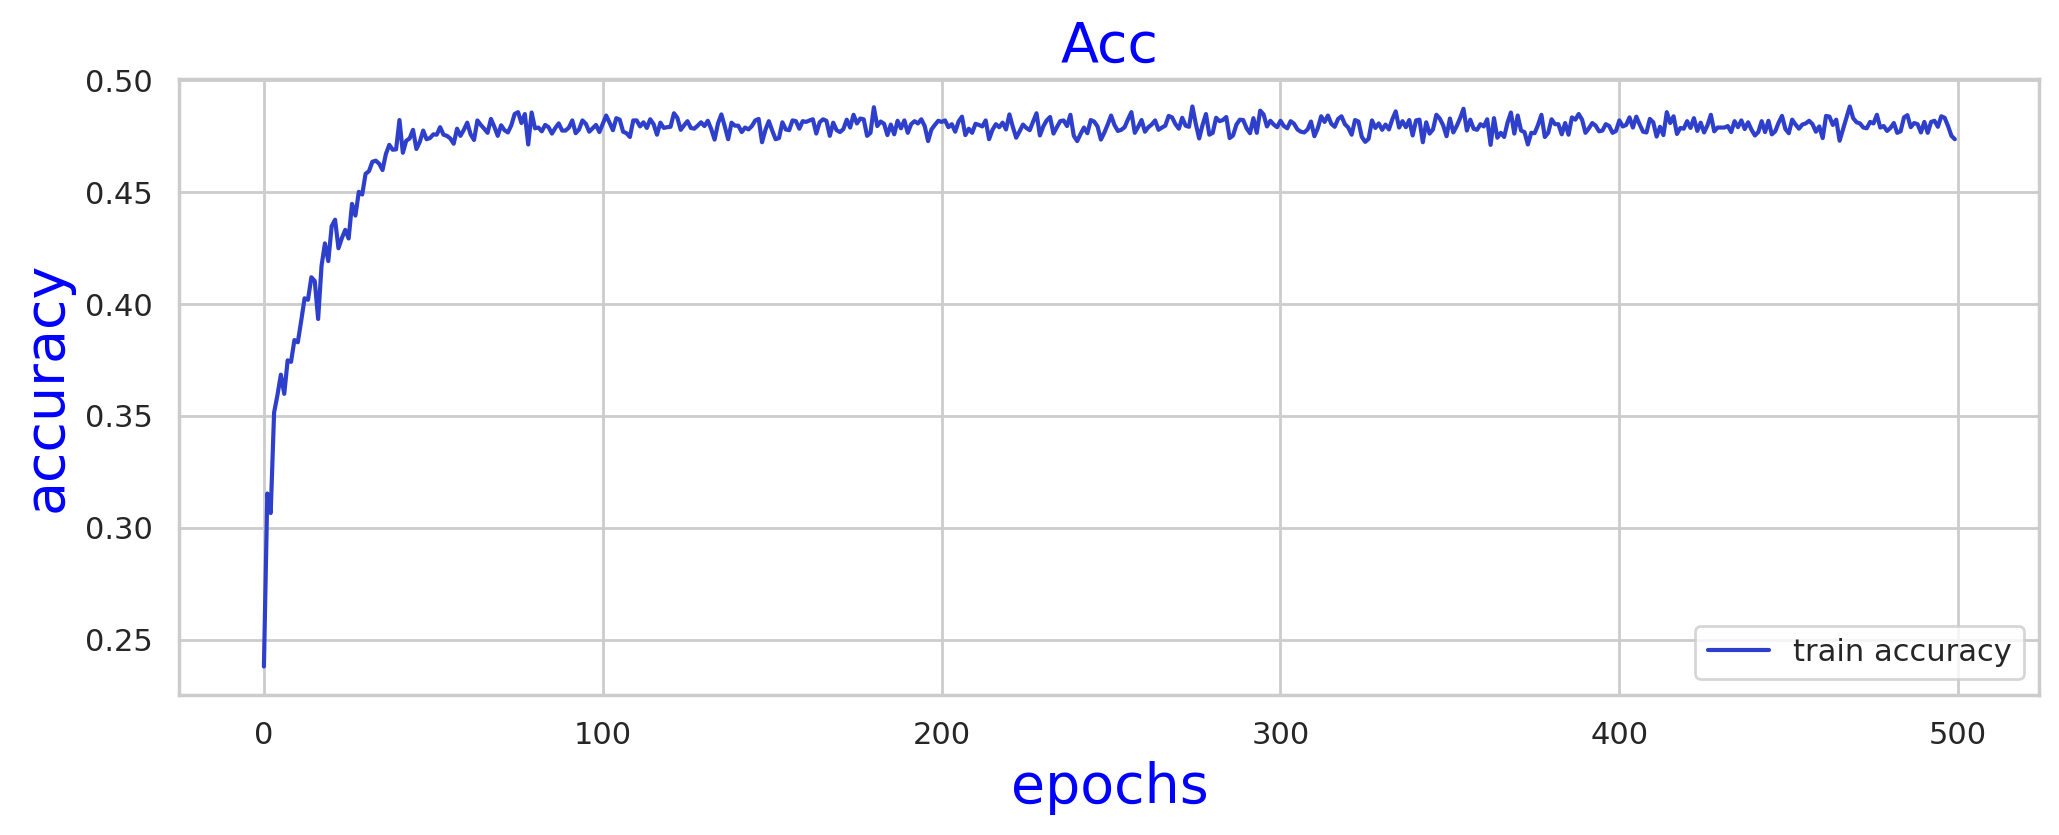

In [64]:
##Evaluation##
epochs = list(range(500))
acc = history.history['accuracy']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(epochs, acc, label='train accuracy', color='#2E40CB')
plt.xlabel('epochs', fontdict= font2)
plt.ylabel('accuracy', fontdict= font2)
plt.title('Acc', fontdict= font2)
plt.legend()
plt.show()

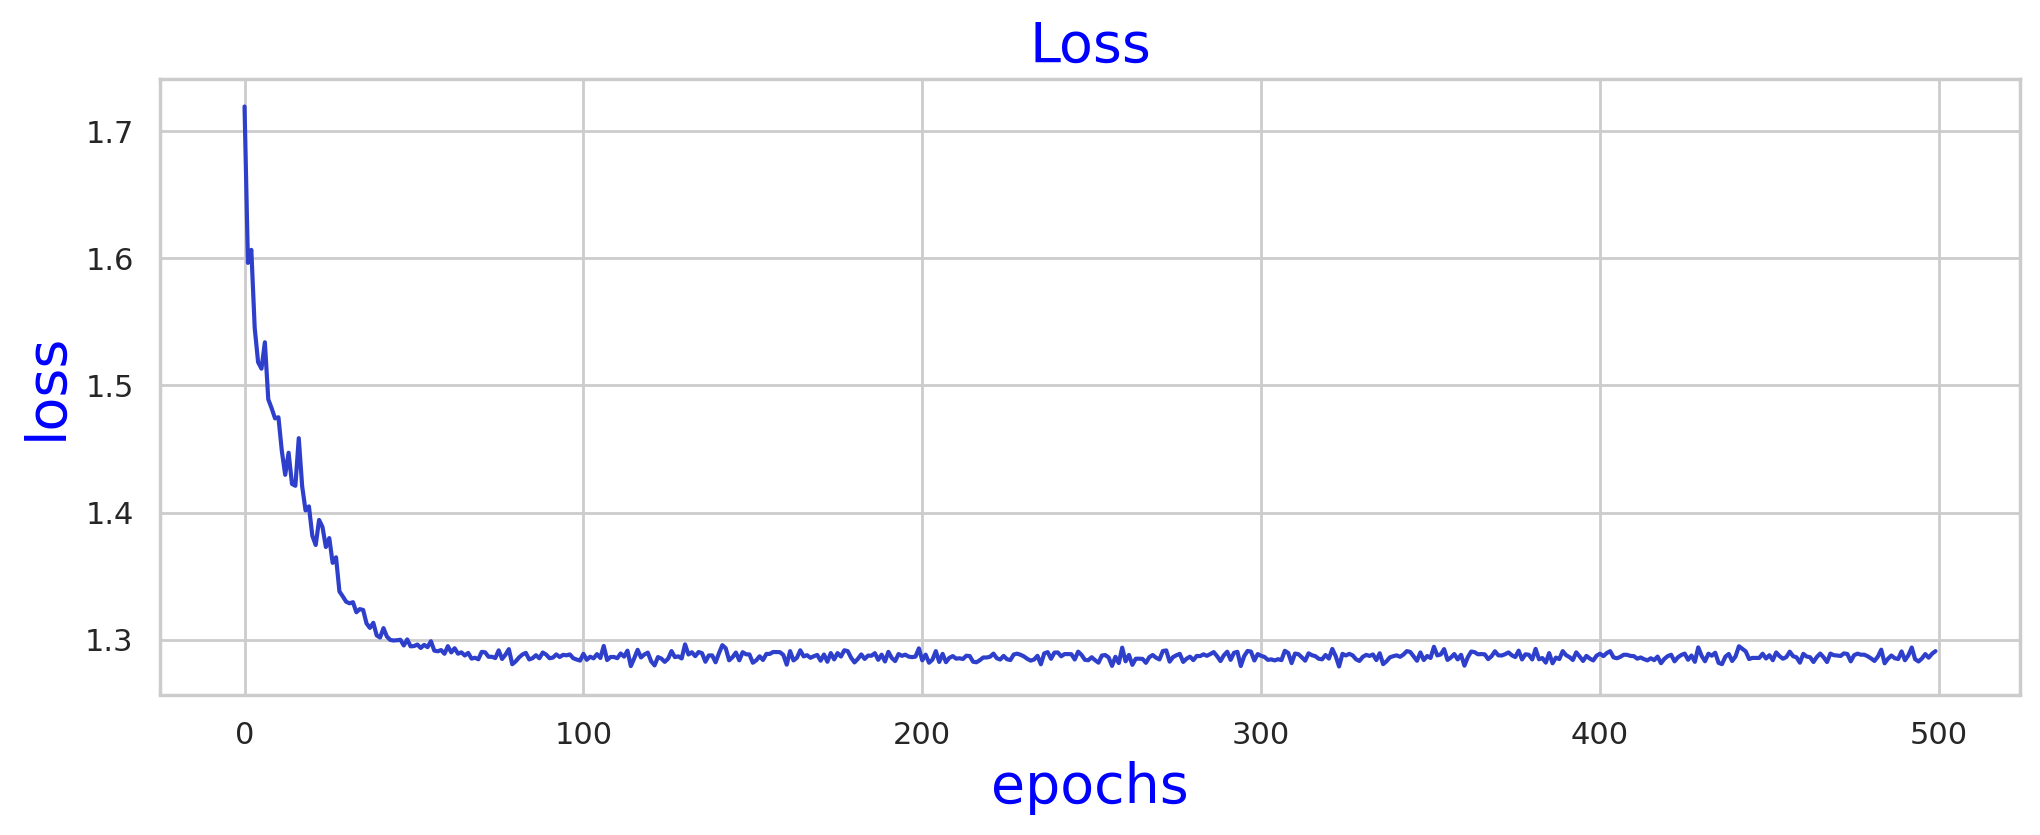

In [65]:
loss = history.history['loss']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(epochs, loss, label='train loss', color='#2E40CB')
plt.xlabel('epochs', fontdict= font2)
plt.ylabel('loss', fontdict= font2)
plt.title('Loss', fontdict= font2)
plt.show()